# Lab-1 (Варіант 3. Лісова пожежа.)

## Part 1
+ Для моделі лісової пожежі з вітром (потрібно розібратись як вона працює, опис є в книзі Rand Wilensky Agent Based Modeling... або на ютуб каналі Complexity Explorer).
+ На основі експериментів побудувати оцінку ймовірності проходження пожежі через ліс (від лівого краю до правого) в залежності від густини лісу та напрямку вітру (в градусах). Величину вітру зафіксувати і не змінювати протягом експериментів. 

## Part 2
+ Додати фактор вирубки. Параметри: паттерн вирубки. Спочатку додати ліс на всі патчі, потім “вирубити” частину дерев (щоб лишився заданий відсоток) за різною схему - випадкові масові вирубки суцільними площами, лінії - вирубка смугами, вирубка окремими точками.    
+ Побудувати залежність між паттерном вирубки, густиною лісу і вітром.

## Modules importing

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit

from pathlib import Path
from typing import List, Dict, Tuple, Union, Optional

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Settings

In [3]:
PATH2PROJECT = Path('')

In [4]:
SEED = 42

## Data Loading

### Part 1 - probability-spread-to-westbound

In [5]:
df_1 = pd.read_csv(PATH2PROJECT / 'probability-spread-to-westbound-table.csv', skiprows=6)
df_1.shape

(45900, 7)

### Part 2 - dependency-between-parameters

In [6]:
df_2 = pd.read_csv(PATH2PROJECT / 'dependency-between-parameters-table.csv', skiprows=6)
df_2 = df_2.rename(columns={'((count patches with [shade-of? pcolor red]) / initial-trees) * 100': 'percent-burned'})
df_2.shape

(11250, 11)

## Solution: Part 1

### Simple EDA

In [7]:
def print_number_of_unqiue_values(df: pd.DataFrame) -> None:
    for col in df.columns:
        print(col, '-', df[col].unique().shape[0])

In [8]:
print_number_of_unqiue_values(df_1)

[run number] - 45900
density - 102
probability-of-spread - 1
west-wind-speed - 3
south-wind-speed - 3
[step] - 831
is-spread-to-westbound - 2


In [9]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45900 entries, 0 to 45899
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   [run number]            45900 non-null  int64
 1   density                 45900 non-null  int64
 2   probability-of-spread   45900 non-null  int64
 3   west-wind-speed         45900 non-null  int64
 4   south-wind-speed        45900 non-null  int64
 5   [step]                  45900 non-null  int64
 6   is-spread-to-westbound  45900 non-null  bool 
dtypes: bool(1), int64(6)
memory usage: 2.1 MB


In [10]:
df_1.sample(10, random_state=SEED)

[run number]  density  probability-of-spread  west-wind-speed  \
5411           5412       12                     90              -20   
32189         32190       71                     90                0   
38383         38384       85                     90              -20   
37821         37822       84                     90              -20   
12384         12385       27                     90                0   
41254         41255       91                     90               20   
15578         15579       34                     90                0   
34278         34278       76                     90              -20   
30347         30345       67                     90                0   
15500         15501       34                     90                0   

       south-wind-speed  [step]  is-spread-to-westbound  
5411                -20       3                   False  
32189                 0     443                    True  
38383                20     398                    True  
37821               -20     403                    True  
12384                 0       5                   False  
41254               -20     293                    True  
15578                20      13                   False  
34278                 0     474                    True  
30347               -20     437                    True  
15500                 0      16                   False

### Estimate probability

In [11]:
df_1_res = df_1.groupby(['density', 'west-wind-speed', 'south-wind-speed'])[['is-spread-to-westbound']].mean().reset_index()
df_1_res.sample(10, random_state=SEED)

density  west-wind-speed  south-wind-speed  is-spread-to-westbound
668       74              -20                20                    0.94
30         3                0               -20                    0.00
377       41               20                20                    0.00
535       59                0                 0                    0.00
807       89               20               -20                    1.00
793       88              -20                 0                    1.00
363       40                0               -20                    0.00
583       64               20                 0                    0.70
165       18                0               -20                    0.00
483       53               20               -20                    0.00

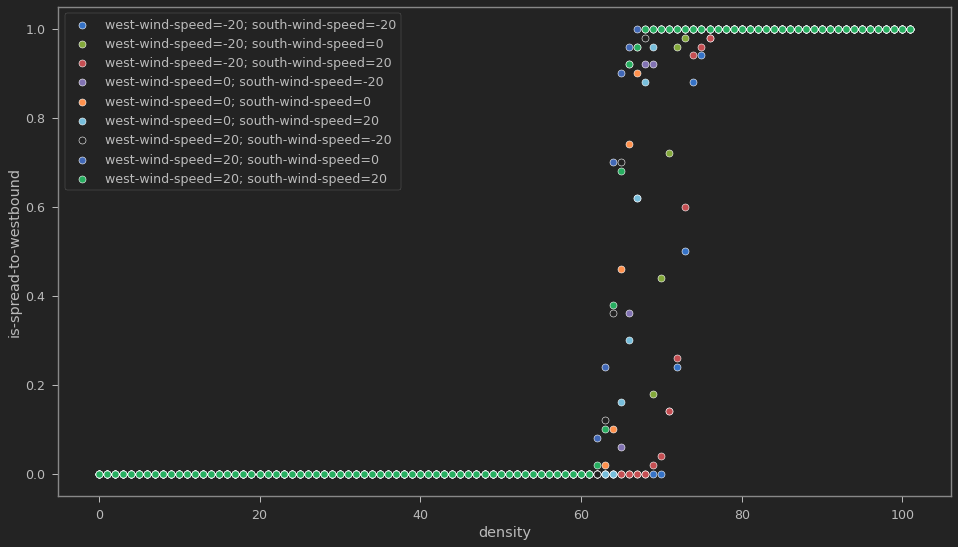

In [15]:
fix, ax = plt.subplots(1,1, figsize=(16, 9))
for west, south in df_1_res[['west-wind-speed', 'south-wind-speed']].drop_duplicates().values:
    t = df_1_res[(df_1_res['west-wind-speed'] == west)&(df_1_res['south-wind-speed'] == south)]
    
    sns.scatterplot(data=t, x='density', y='is-spread-to-westbound', ax=ax, label=f'west-wind-speed={west}; south-wind-speed={south}');
    ax.legend()

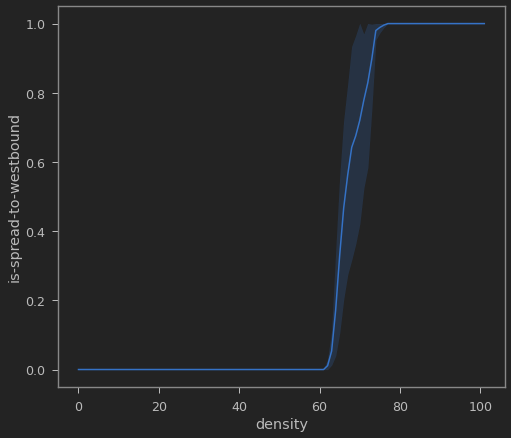

In [12]:
sns.lineplot(data=df_1_res, x='density', y='is-spread-to-westbound');

### Estimate proba using sigmoid function

In [13]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

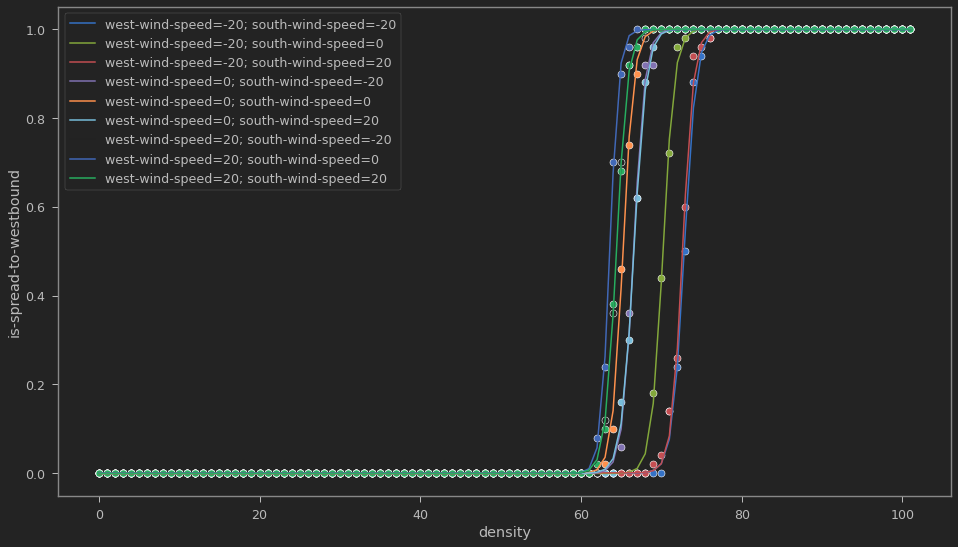

In [132]:
fix, ax = plt.subplots(1,1, figsize=(16, 9))
for west, south in df_1_res[['west-wind-speed', 'south-wind-speed']].drop_duplicates().values:
    t = df_1_res[(df_1_res['west-wind-speed'] == west)&(df_1_res['south-wind-speed'] == south)]
    
    p0 = [max(t['is-spread-to-westbound']), np.median(t['density']), 1, min(t['is-spread-to-westbound'])]
    popt, pcov = curve_fit(sigmoid, t['density'], t['is-spread-to-westbound'],p0, method='dogbox')
    
    sns.scatterplot(data=t, x='density', y='is-spread-to-westbound', ax=ax);
    ax.plot(t['density'], sigmoid(t['density'], *popt), '-', label=f'west-wind-speed={west}; south-wind-speed={south}')
    ax.legend()

## Solution: Part 2

### Simple EDA

In [84]:
print_number_of_unqiue_values(df_2)

[run number] - 11250
density - 9
probability-of-felling - 1
count-of-felling-points - 1
probability-of-spread - 1
west-wind-speed - 5
width-of-felling - 1
south-wind-speed - 5
felling-strategy - 5
[step] - 650
is-spread-to-westbound - 2


In [85]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11250 entries, 0 to 11249
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   [run number]             11250 non-null  int64 
 1   density                  11250 non-null  int64 
 2   probability-of-felling   11250 non-null  int64 
 3   count-of-felling-points  11250 non-null  int64 
 4   probability-of-spread    11250 non-null  int64 
 5   west-wind-speed          11250 non-null  int64 
 6   width-of-felling         11250 non-null  int64 
 7   south-wind-speed         11250 non-null  int64 
 8   felling-strategy         11250 non-null  object
 9   [step]                   11250 non-null  int64 
 10  is-spread-to-westbound   11250 non-null  bool  
dtypes: bool(1), int64(9), object(1)
memory usage: 890.0+ KB


In [86]:
df_2.sample(10, random_state=SEED)

[run number]  density  probability-of-felling  count-of-felling-points  \
5748          5750       60                      50                       20   
7334          7333       70                      50                       20   
5931          5932       60                      50                       20   
3819          3820       50                      50                       20   
6394          6395       70                      50                       20   
7040          7044       70                      50                       20   
1068          1069       20                      50                       20   
4881          4882       50                      50                       20   
668            670       20                      50                       20   
6553          6552       70                      50                       20   

      probability-of-spread  west-wind-speed  width-of-felling  \
5748                     75                0                 5   
7334                     75               20                 5   
5931                     75               10                 5   
3819                     75              -20                 5   
6394                     75              -20                 5   
7040                     75               10                 5   
1068                     75               20                 5   
4881                     75               20                 5   
668                      75                0                 5   
6553                     75              -10                 5   

      south-wind-speed felling-strategy  [step]  is-spread-to-westbound  
5748                20           Square      26                   False  
7334               -10         XY-lines      96                   False  
5931                10         XY-lines      24                   False  
3819               -10          X-lines       8                   False  
6394                 0           Square      31                   False  
7040               -20           Square     167                   False  
1068               -10          X-lines       5                   False  
4881                 0         XY-lines      20                   False  
668                 10          X-lines       4                   False  
6553               -10          Default     118                   False

### Lineplots

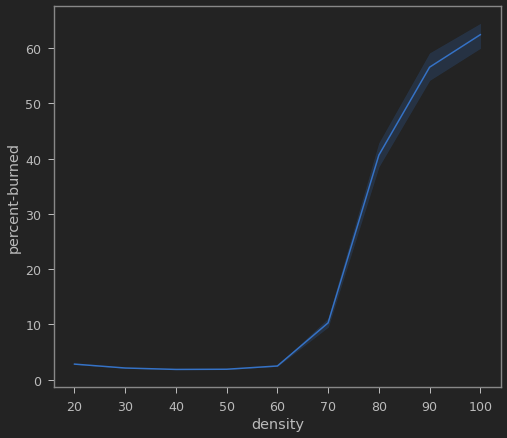

In [33]:
sns.lineplot(data=df_2, x='density', y='percent-burned');

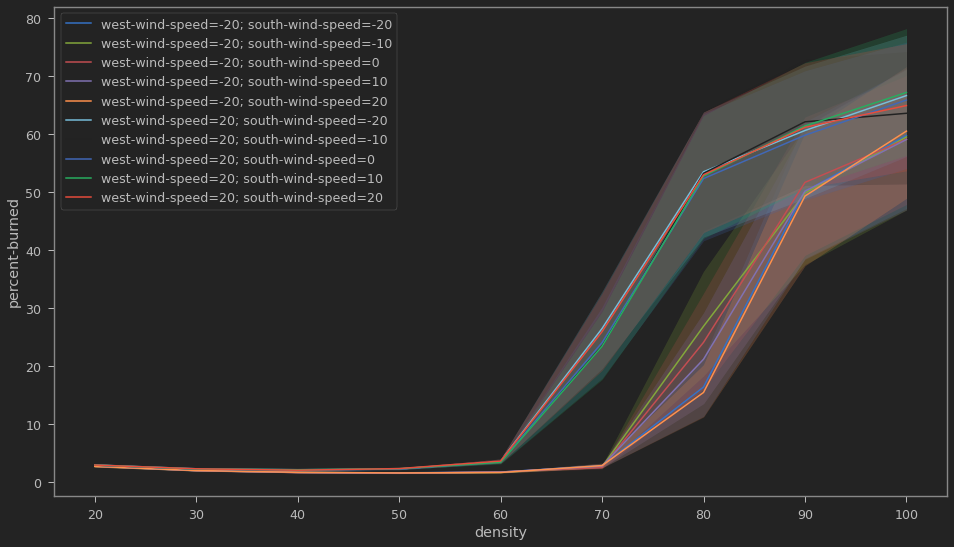

In [36]:
fix, ax = plt.subplots(1,1, figsize=(16, 9))
for west, south in df_2[['west-wind-speed', 'south-wind-speed']].drop_duplicates().values:
    if not (west in {-20, 20}):
        continue
    t = df_2[(df_2['west-wind-speed'] == west)&(df_2['south-wind-speed'] == south)]
    
    sns.lineplot(data=t, x='density', y='percent-burned', ax=ax, label=f'west-wind-speed={west}; south-wind-speed={south}')
#     ax.legend()

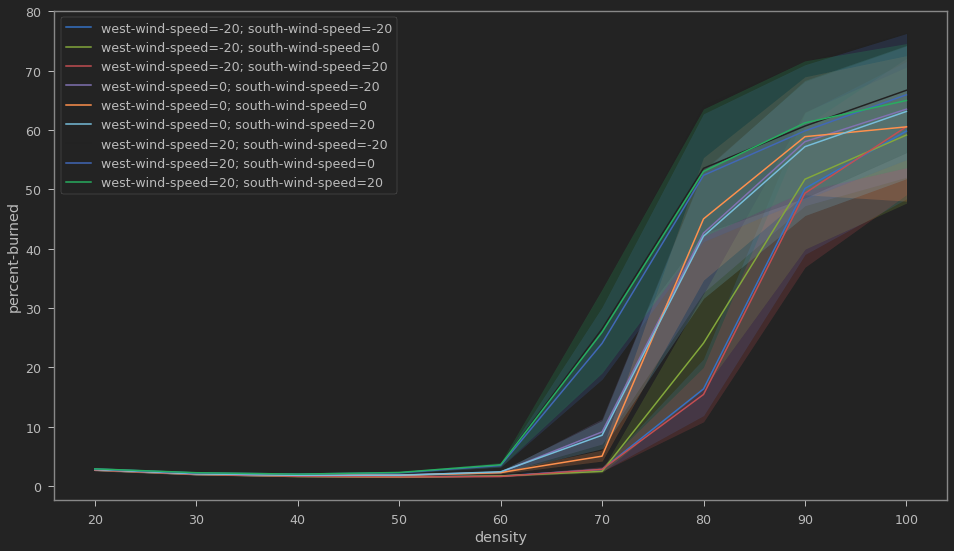

In [43]:
fix, ax = plt.subplots(1,1, figsize=(16, 9))
for west, south in df_2[['west-wind-speed', 'south-wind-speed']].drop_duplicates().values:
    if not (west in {-20, 20, 0} and south in {-20, 20, 0}):
        continue
    t = df_2[(df_2['west-wind-speed'] == west)&(df_2['south-wind-speed'] == south)]
    
    sns.lineplot(data=t, x='density', y='percent-burned', ax=ax, label=f'west-wind-speed={west}; south-wind-speed={south}')
#     ax.legend()

### General dependency: box plots

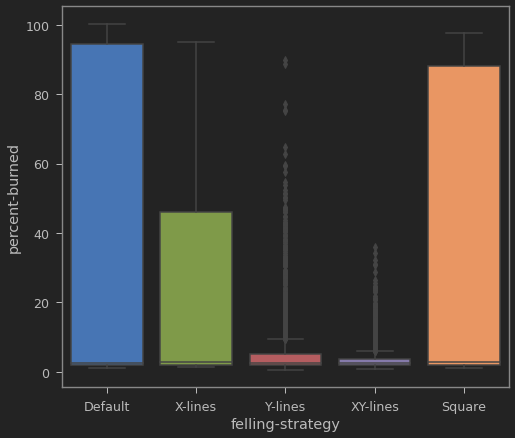

In [17]:
sns.boxplot(data=df_2, x='felling-strategy', y='percent-burned');

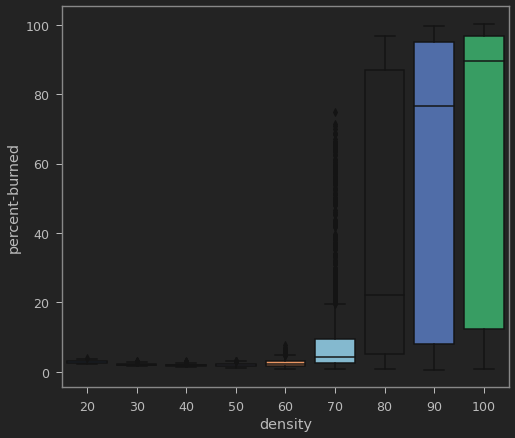

In [18]:
sns.boxplot(data=df_2, x='density', y='percent-burned');

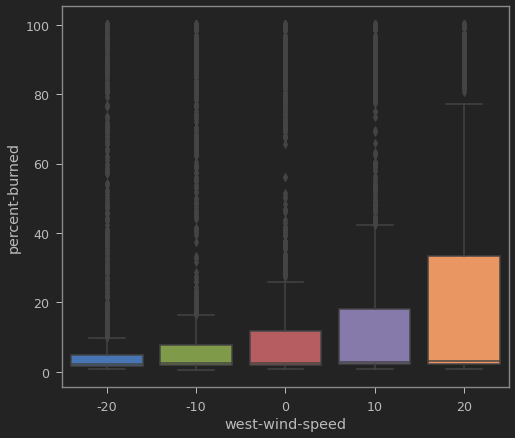

In [108]:
sns.boxplot(data=df_2, x='west-wind-speed', y='percent-burned');

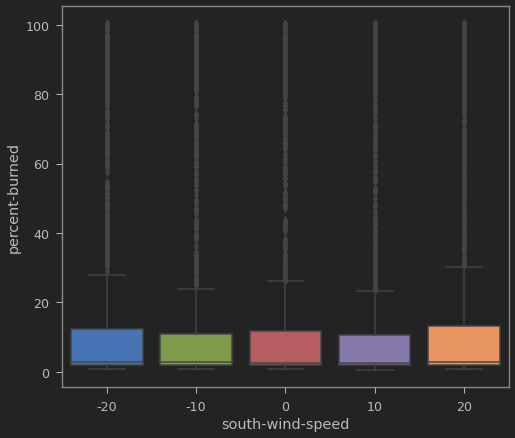

In [109]:
sns.boxplot(data=df_2, x='south-wind-speed', y='percent-burned');

### General dependency: box plots

In [61]:
df_2_res = df_2[df_2['density'] >= 50]

In [62]:
density

100

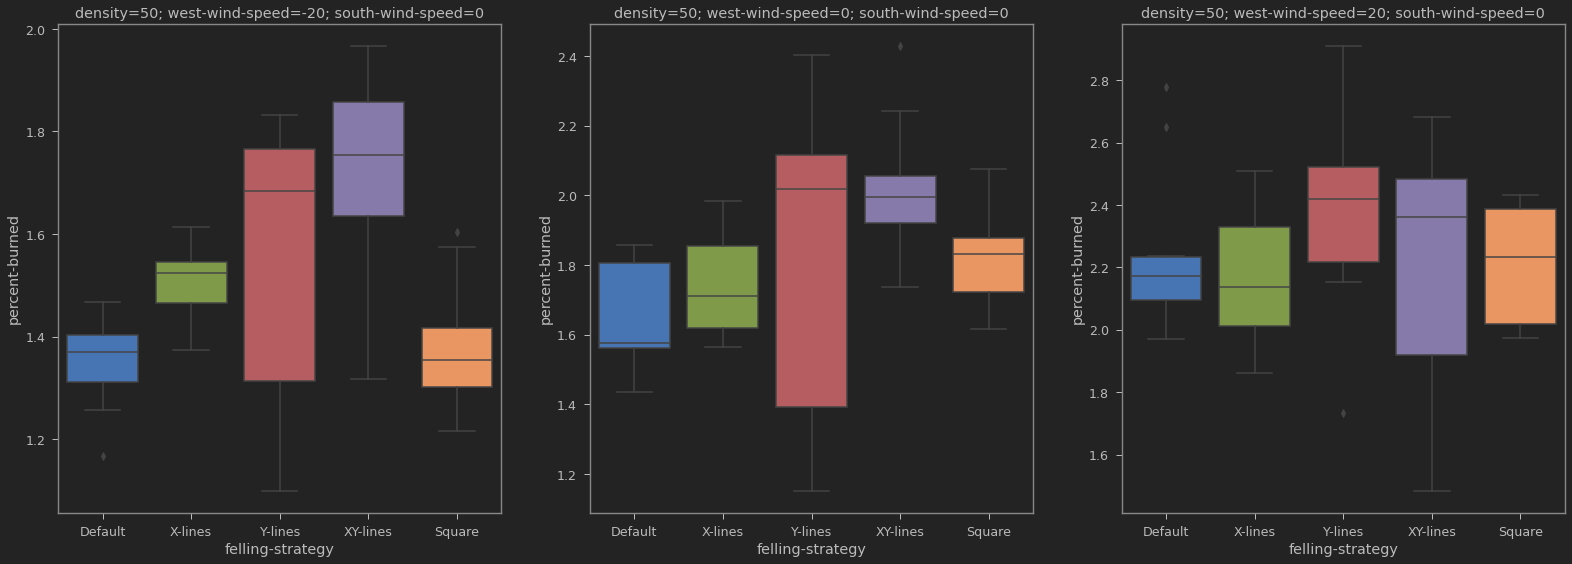

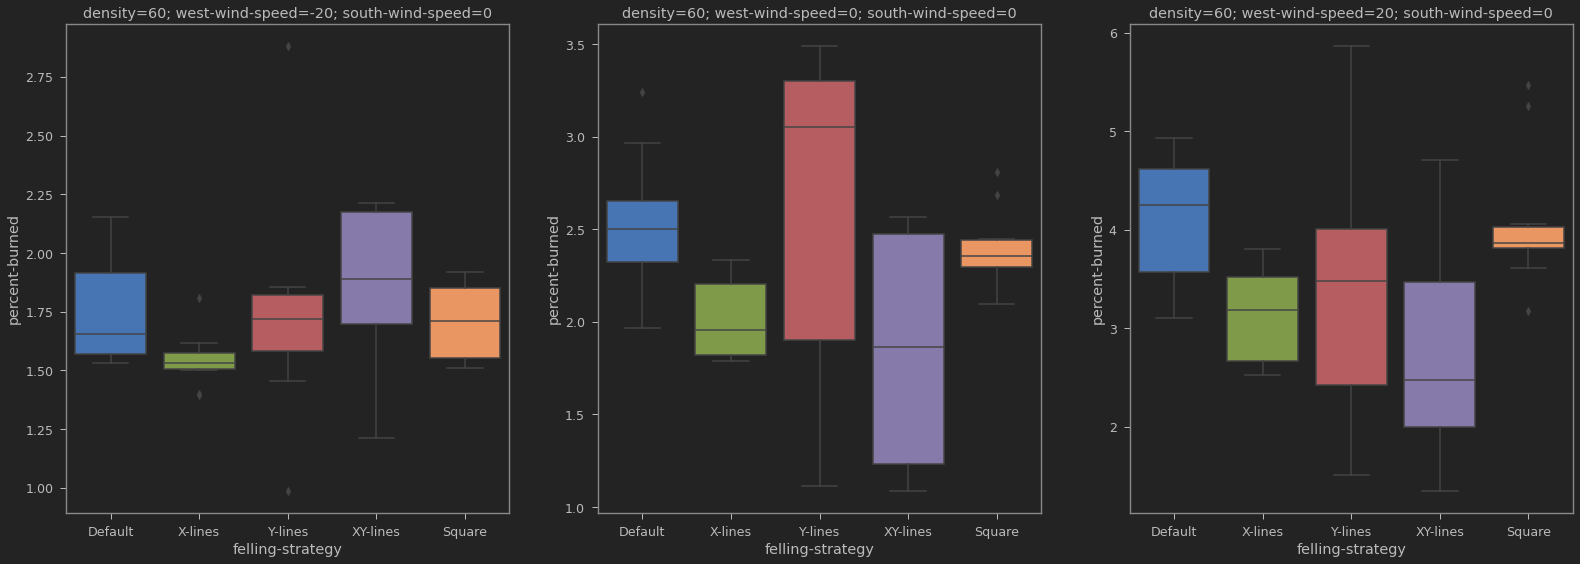

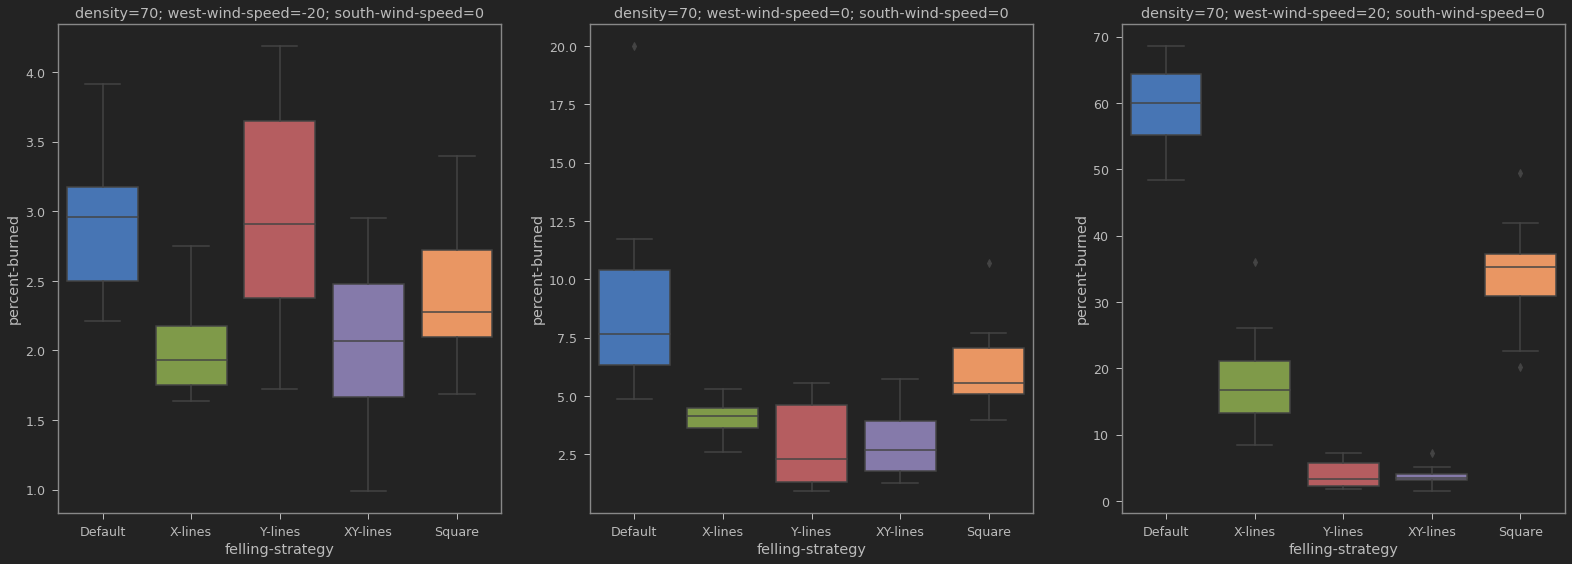

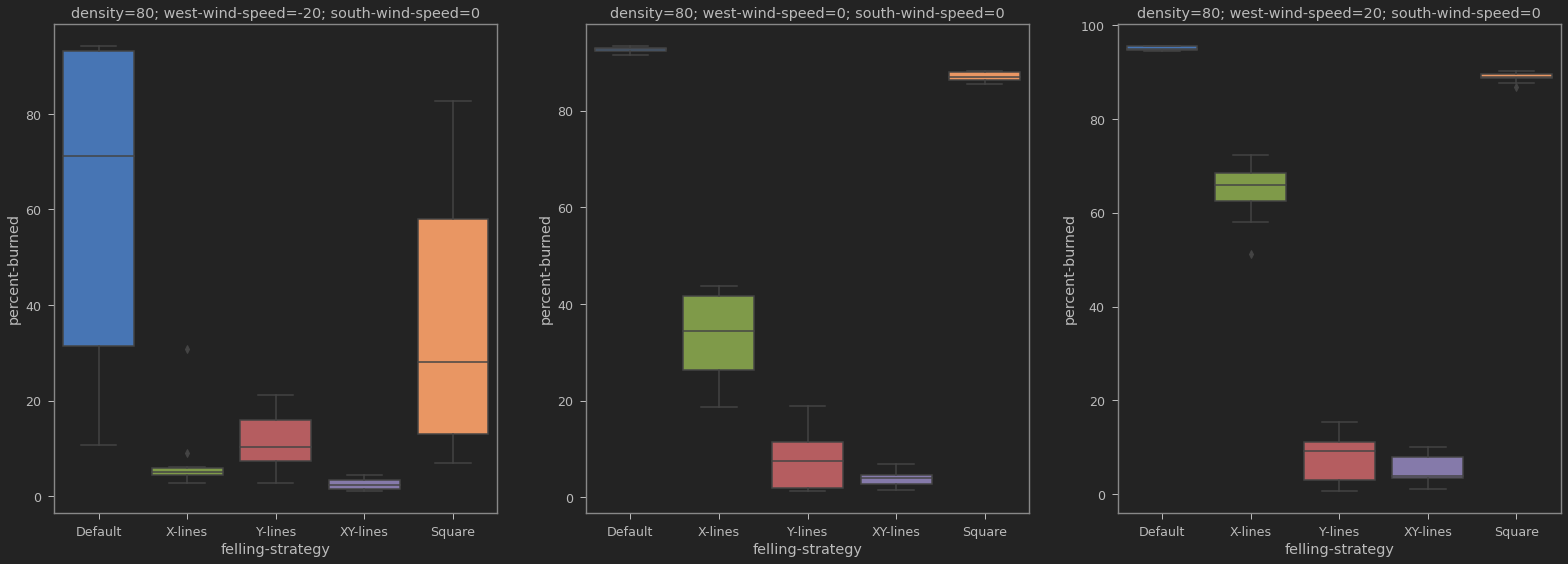

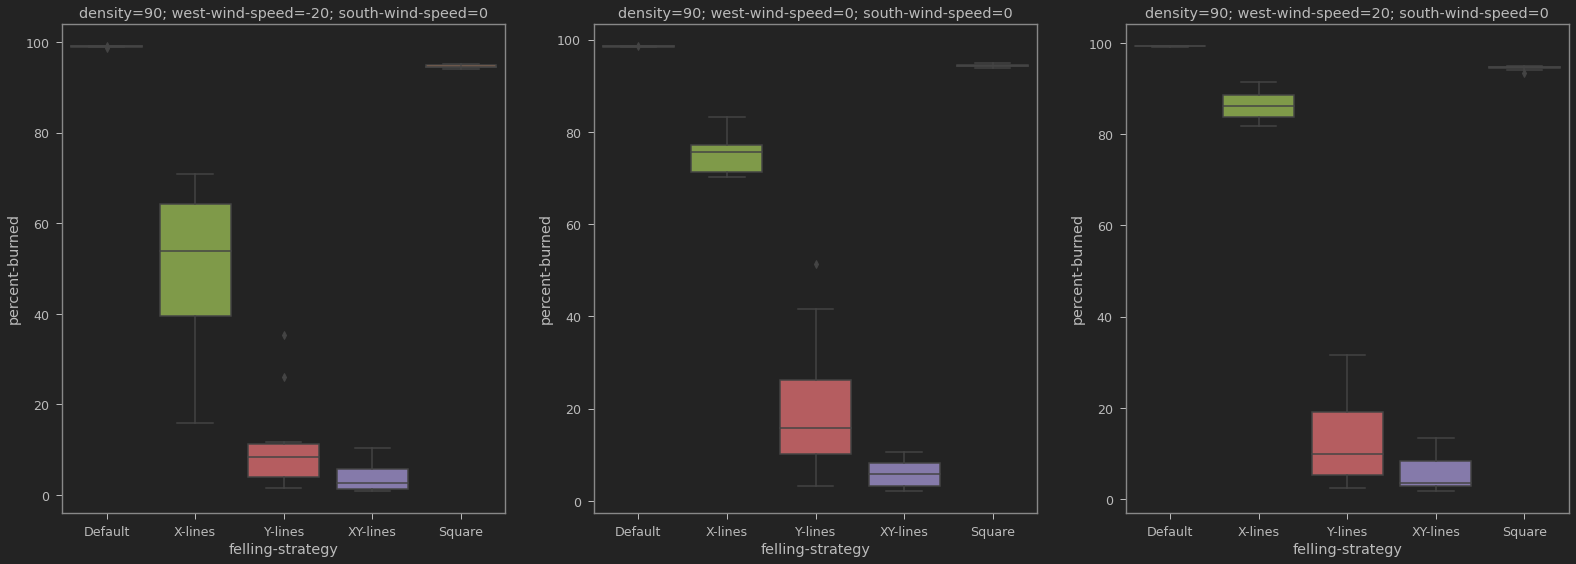

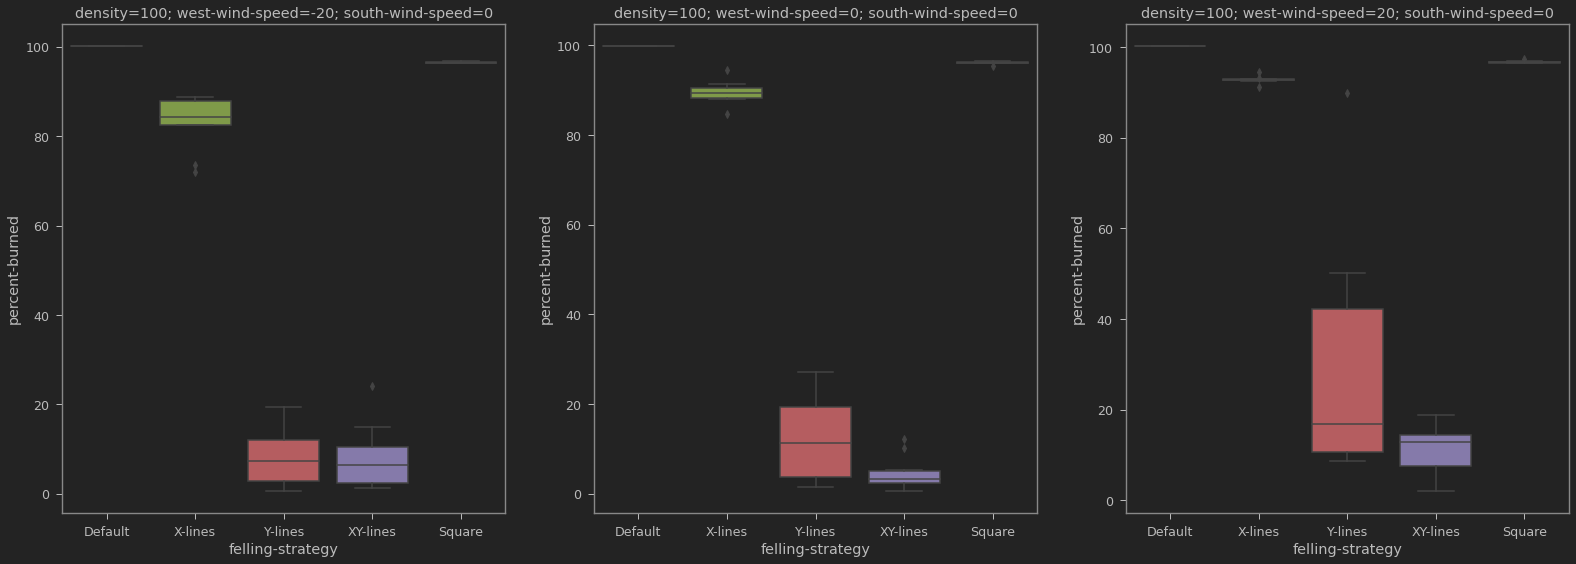

In [64]:
for density in df_2_res['density'].unique():
    fig, axs = plt.subplots(1, 3, figsize=(27,9))
    t1 = df_2_res[(df_2_res['density'] == density)&(df_2_res['west-wind-speed'] == -20)&(df_2_res['south-wind-speed'] == 0)]
    t2 = df_2_res[(df_2_res['density'] == density)&(df_2_res['west-wind-speed'] == 0)&(df_2_res['south-wind-speed'] == 0)]
    t3 = df_2_res[(df_2_res['density'] == density)&(df_2_res['west-wind-speed'] == 20)&(df_2_res['south-wind-speed'] == 0)]
    
    sns.boxplot(data=t1, x='felling-strategy', y='percent-burned', ax=axs[0]);
    sns.boxplot(data=t2, x='felling-strategy', y='percent-burned', ax=axs[1]);
    sns.boxplot(data=t3, x='felling-strategy', y='percent-burned', ax=axs[2]);
    
    axs[0].set_title(f'density={density}; west-wind-speed=-20; south-wind-speed=0')
    axs[1].set_title(f'density={density}; west-wind-speed=0; south-wind-speed=0')
    axs[2].set_title(f'density={density}; west-wind-speed=20; south-wind-speed=0')
    plt.show()

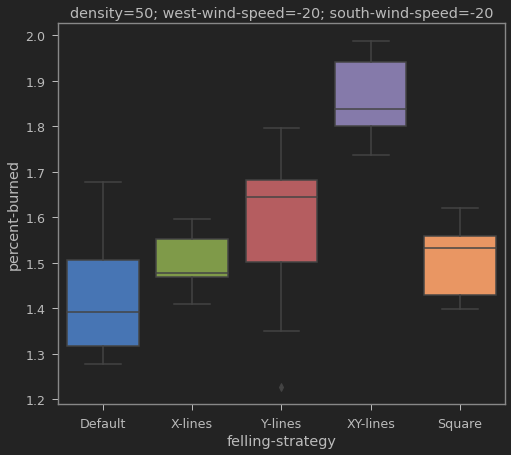

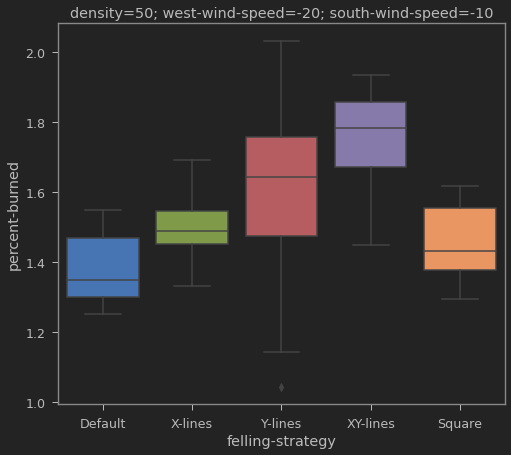

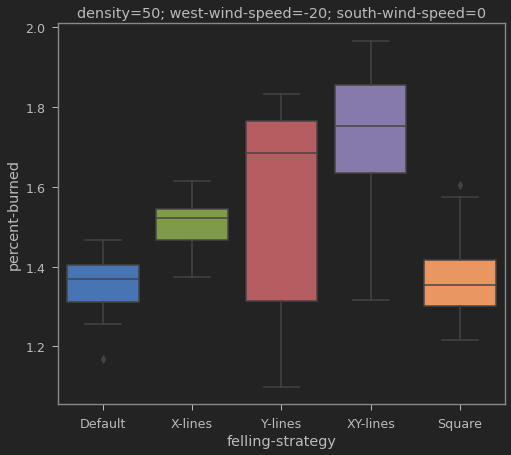

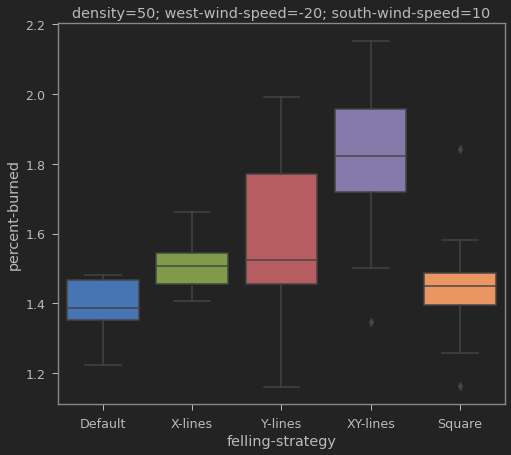

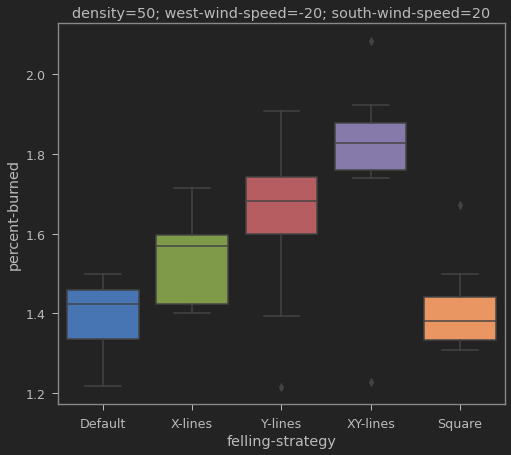

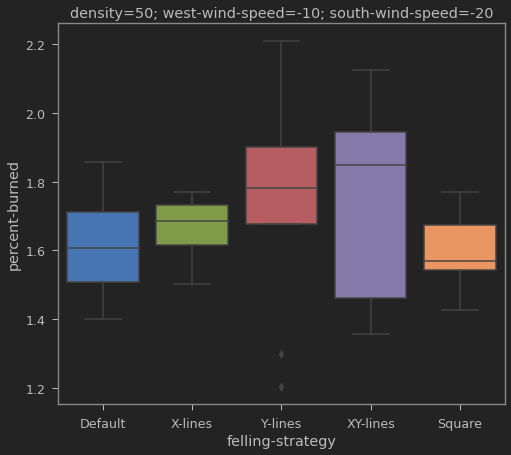

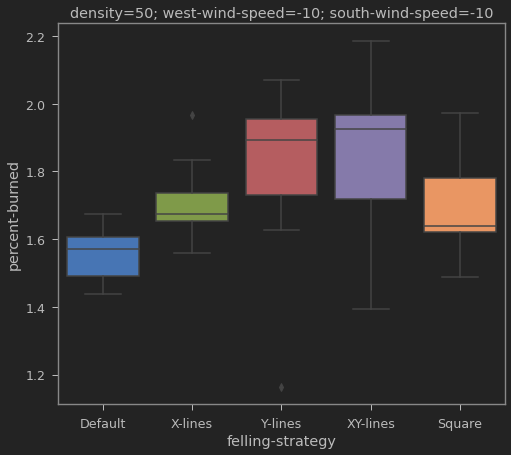

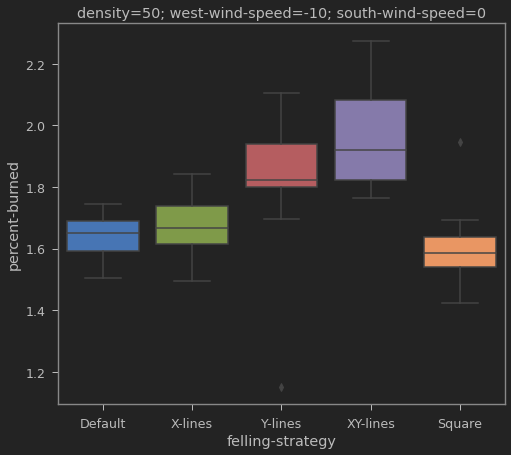

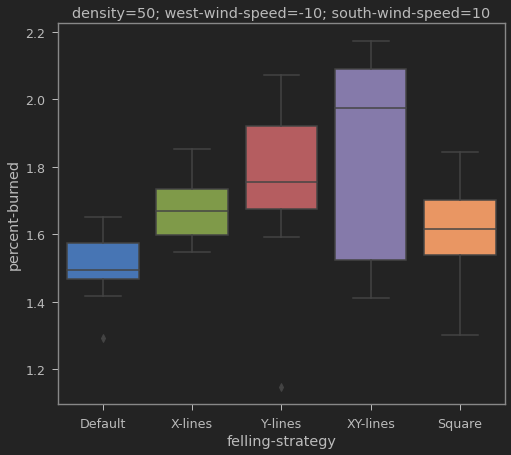

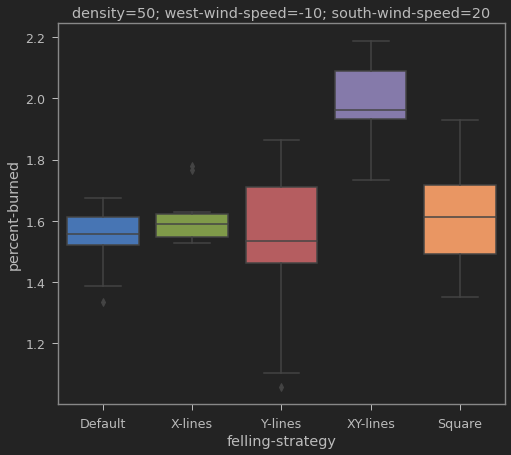

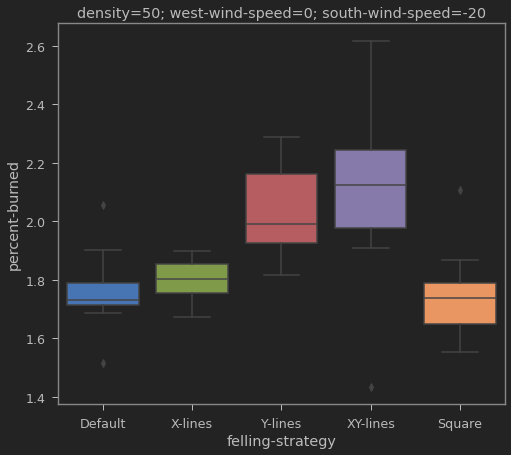

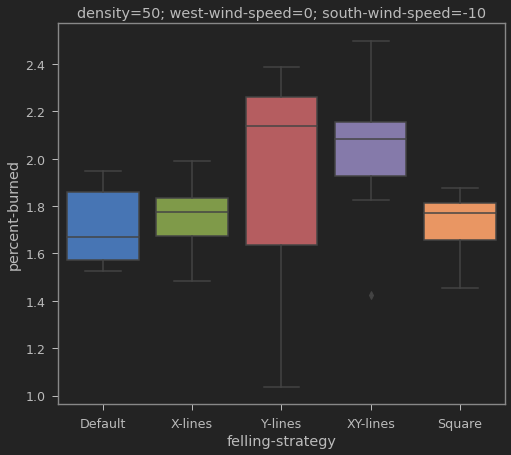

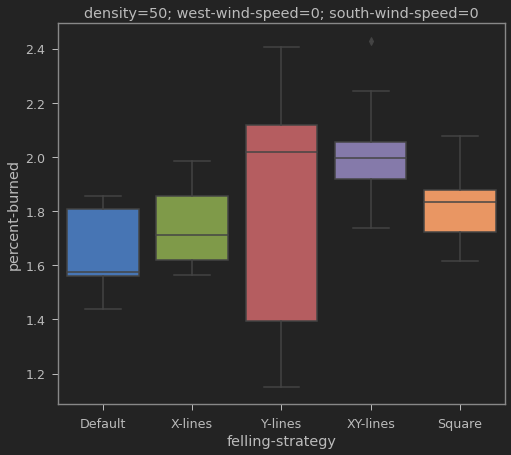

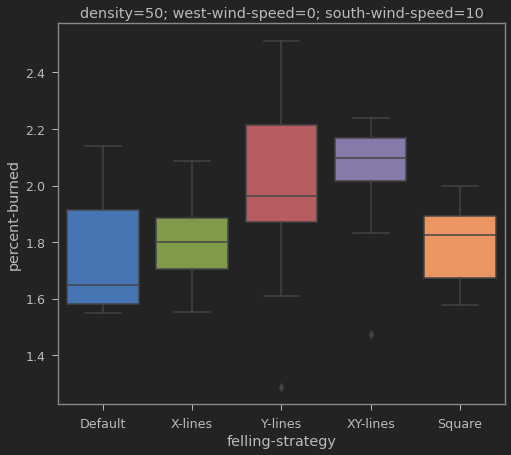

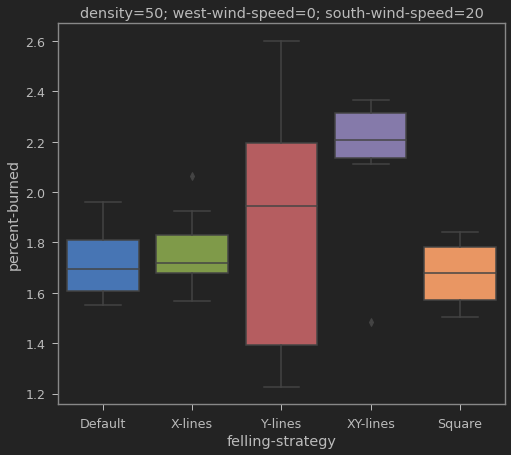

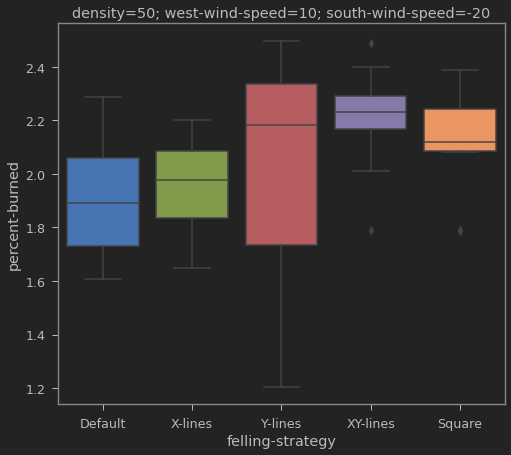

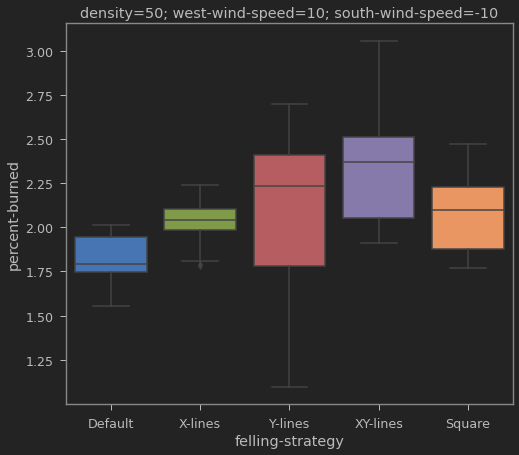

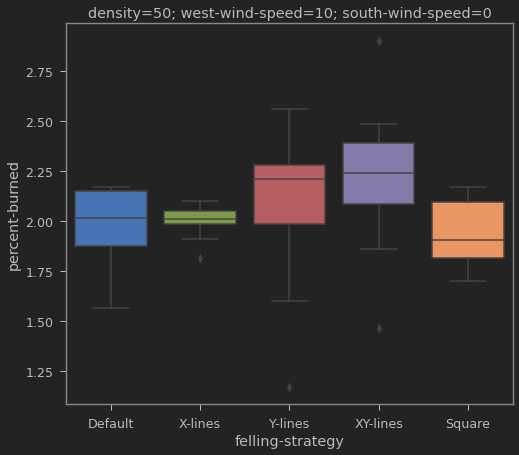

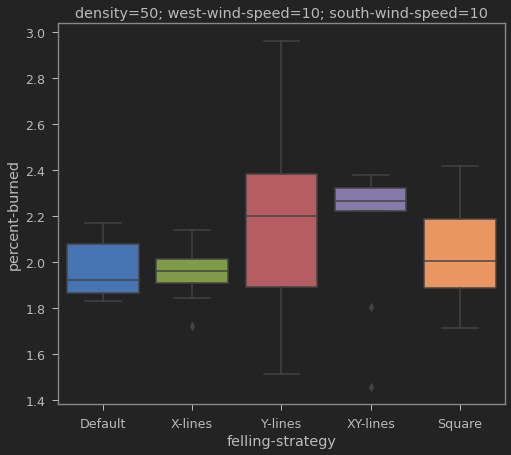

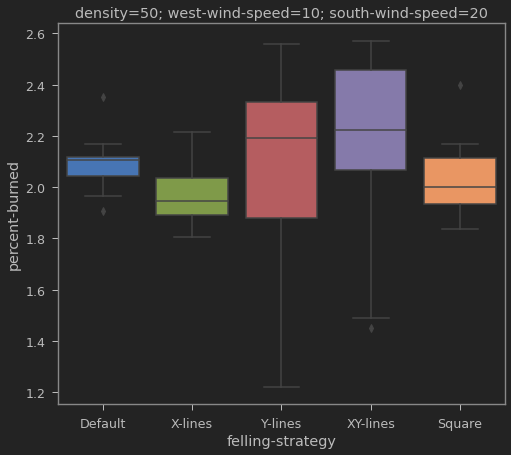

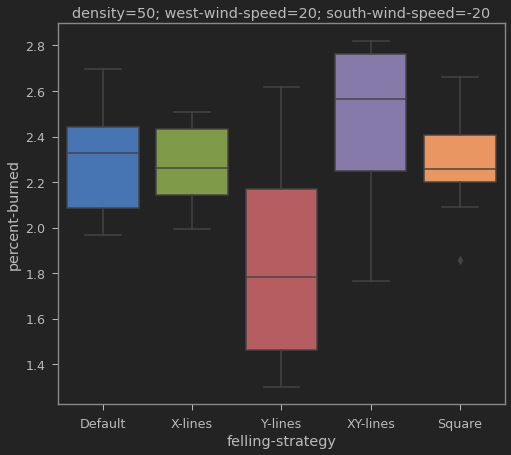

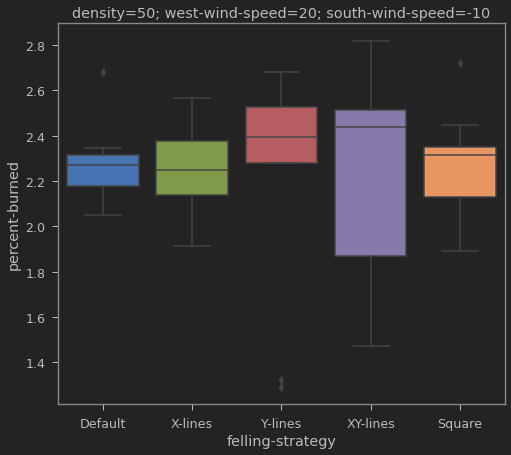

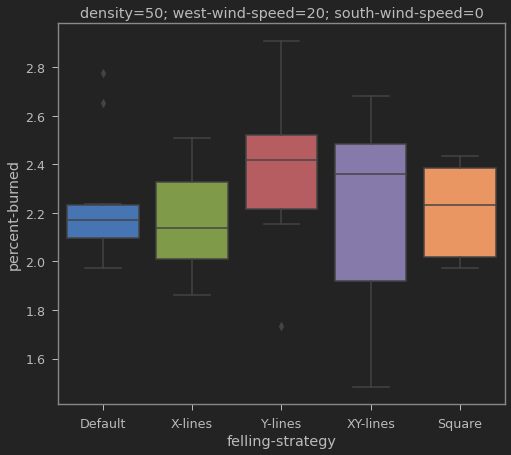

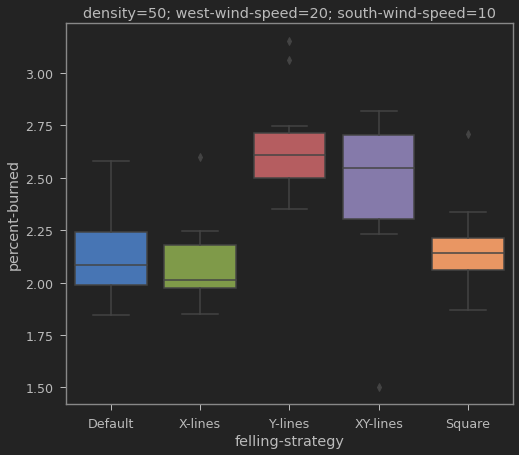

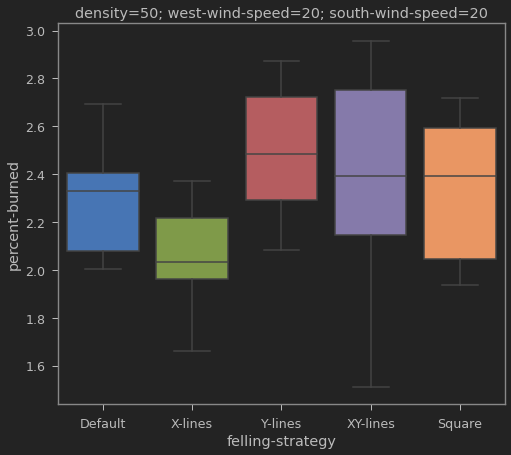

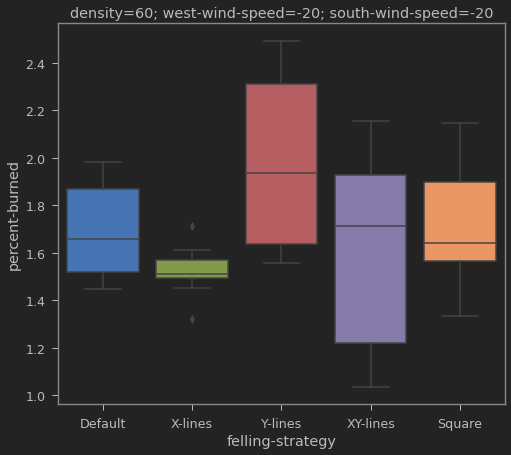

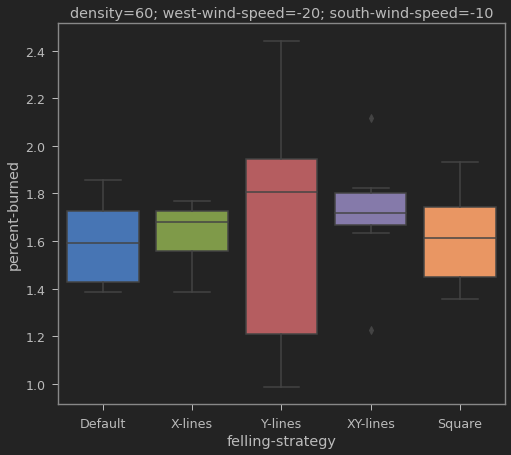

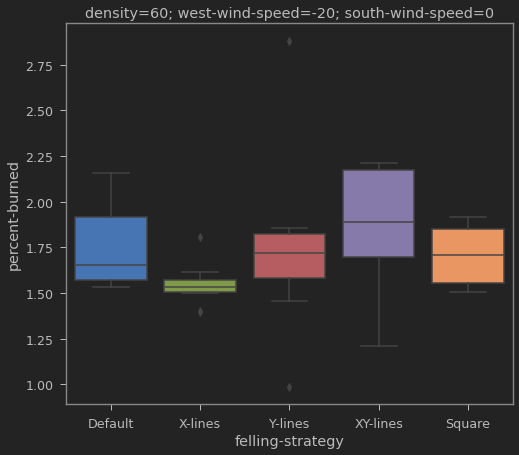

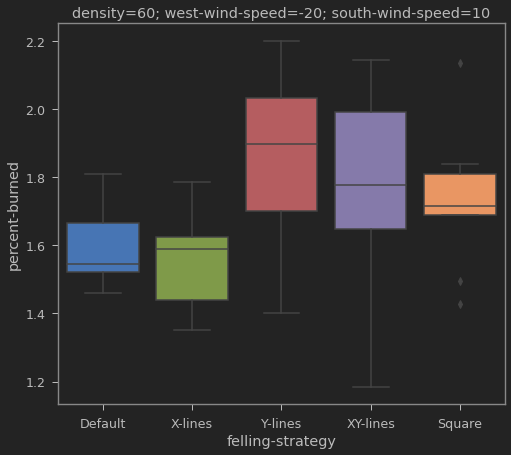

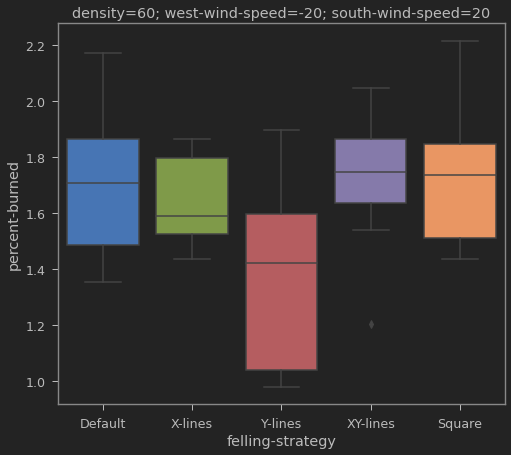

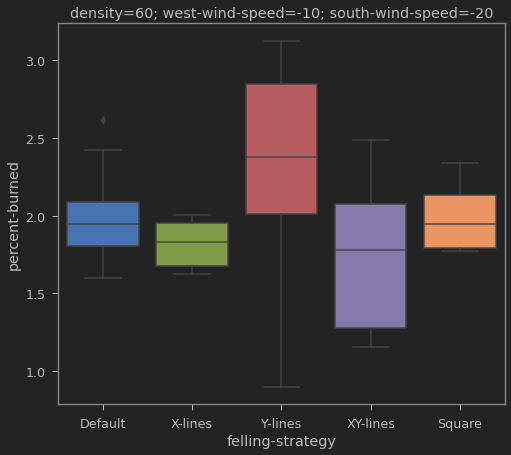

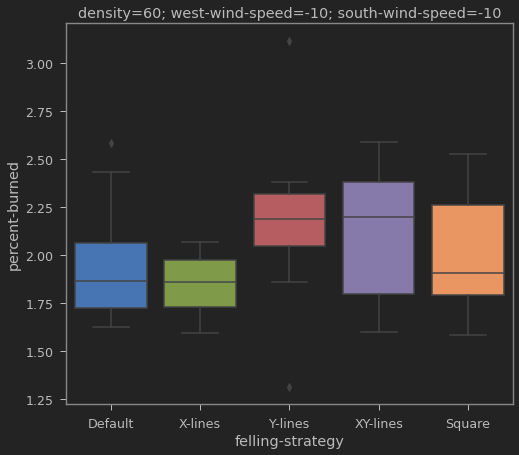

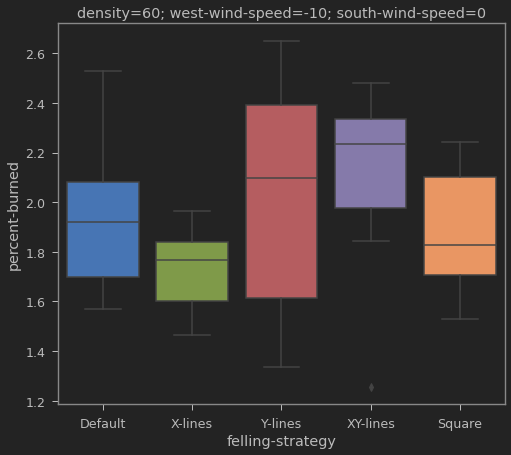

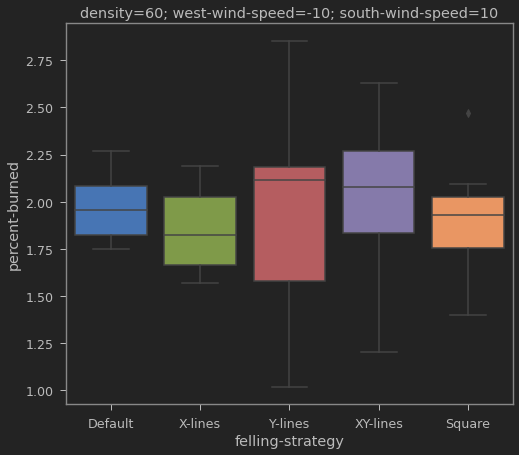

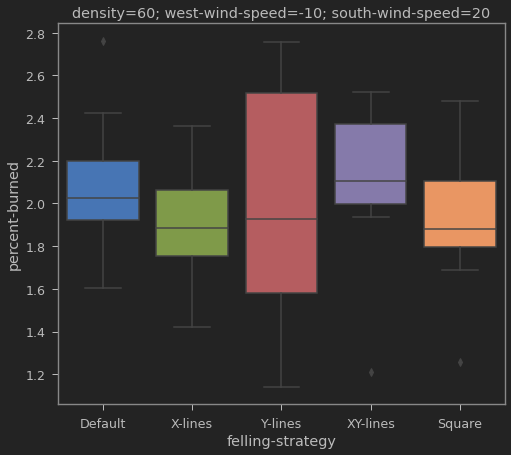

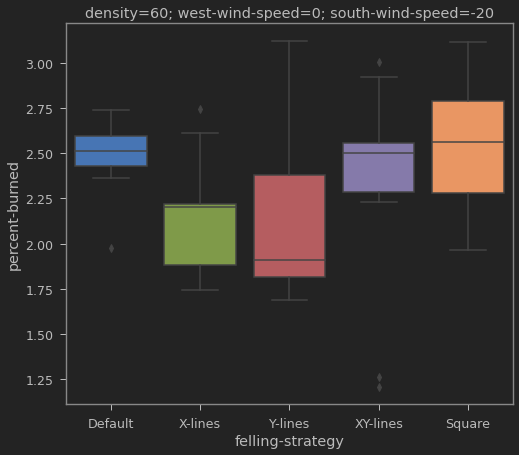

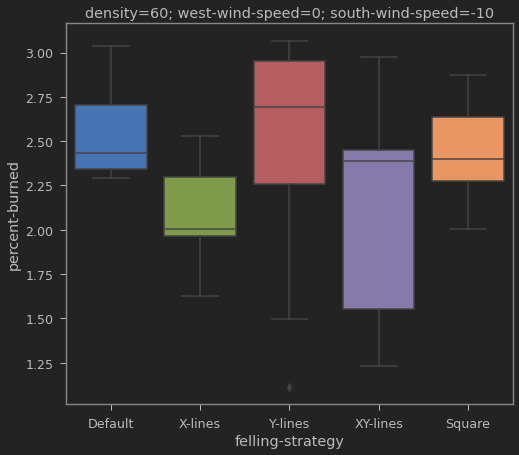

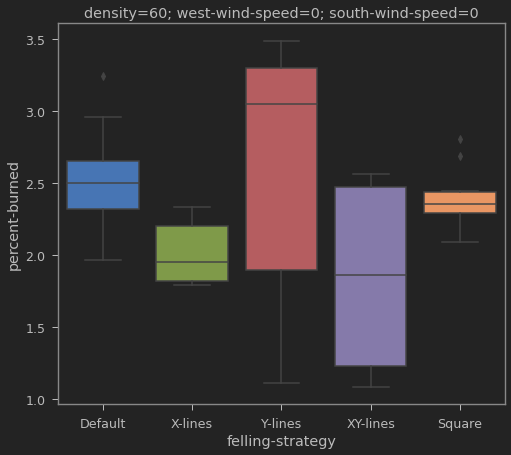

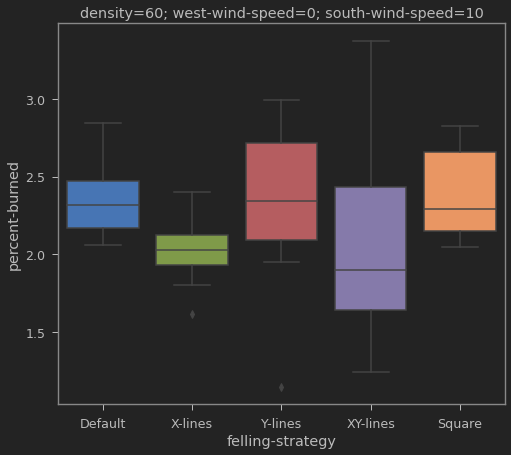

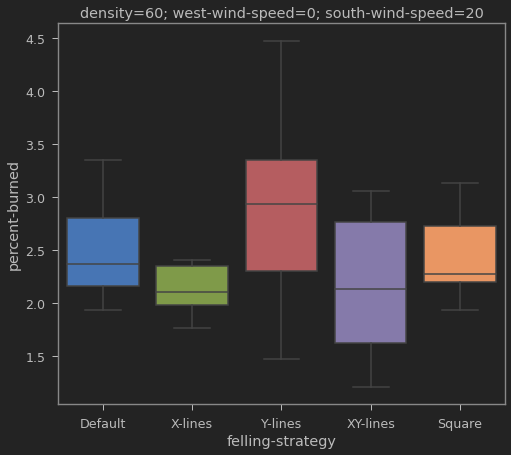

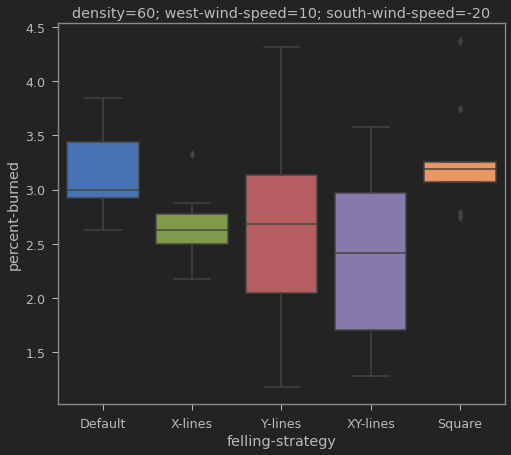

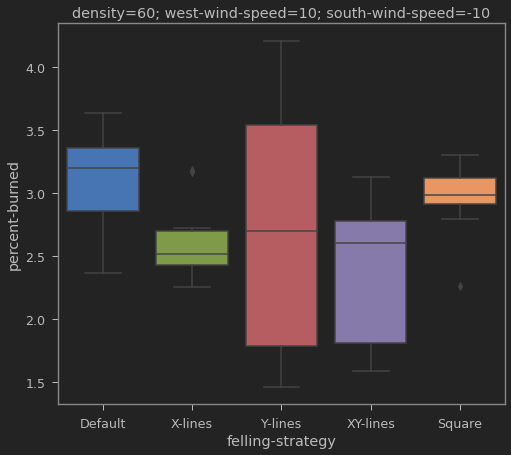

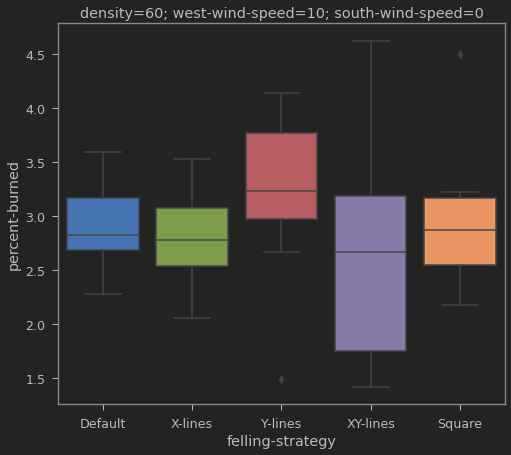

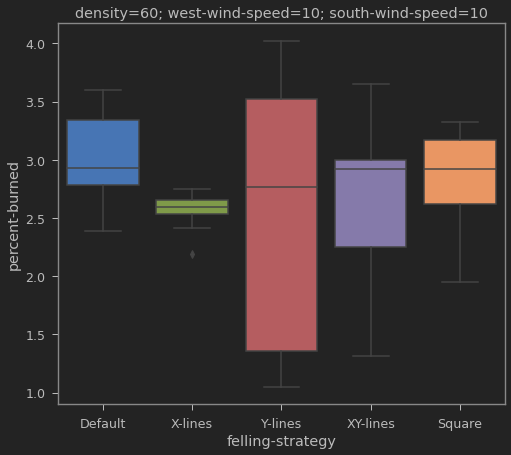

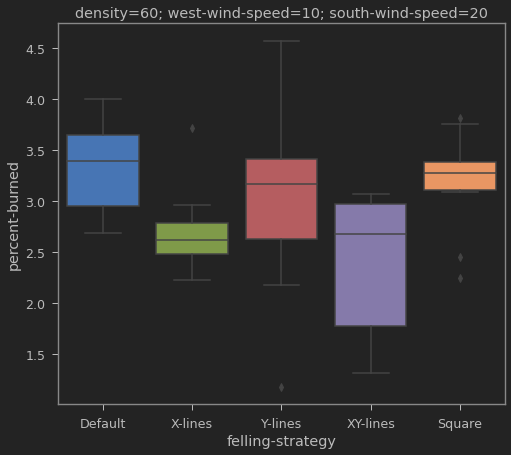

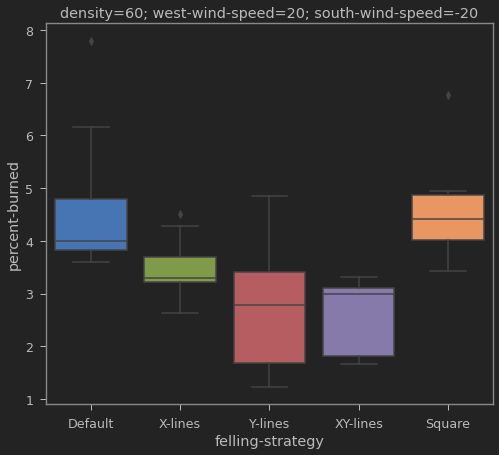

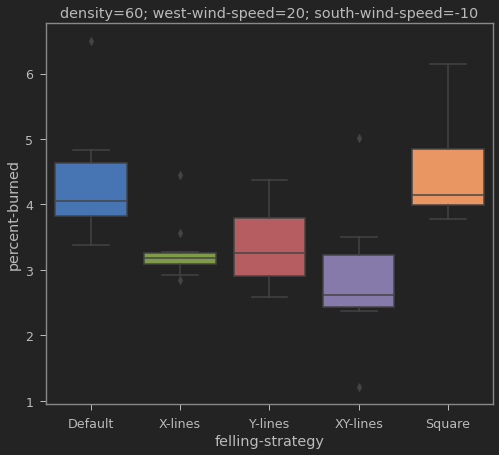

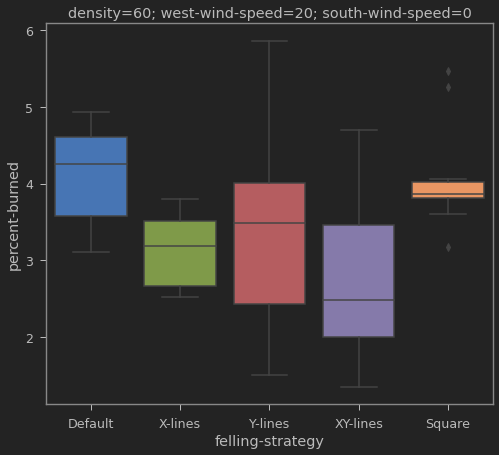

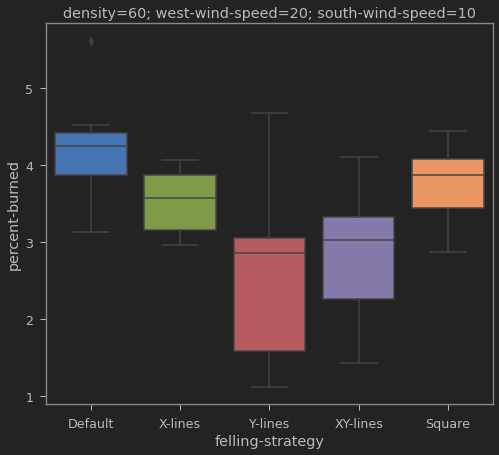

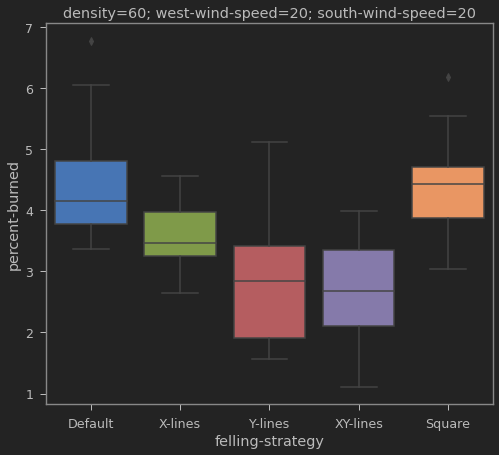

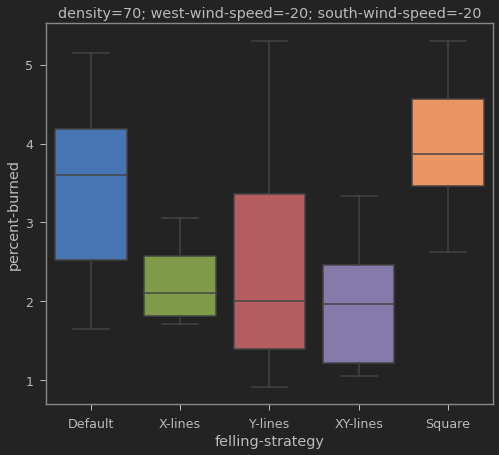

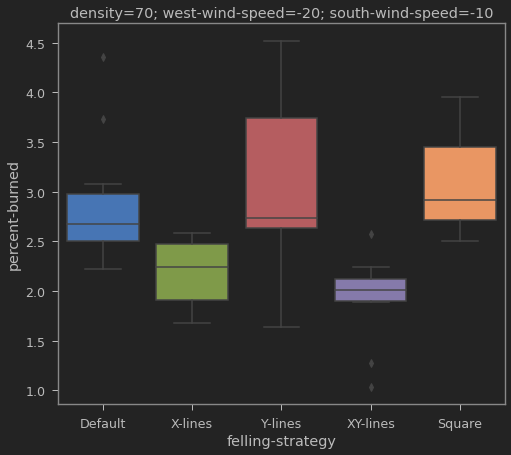

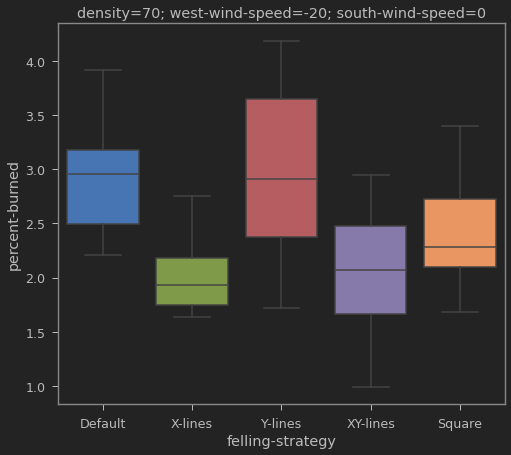

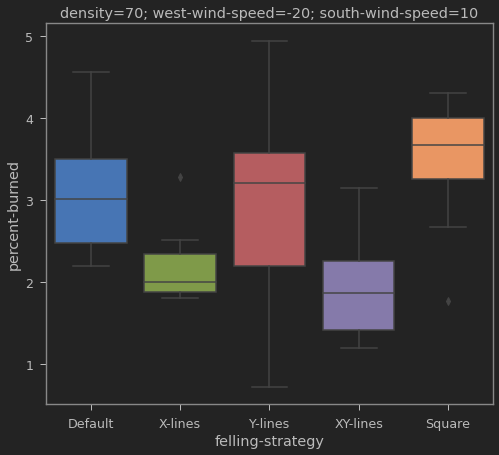

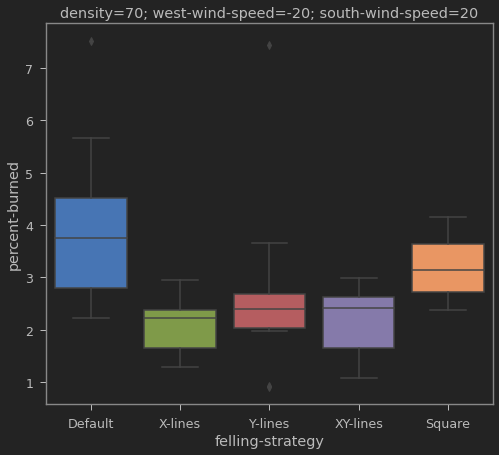

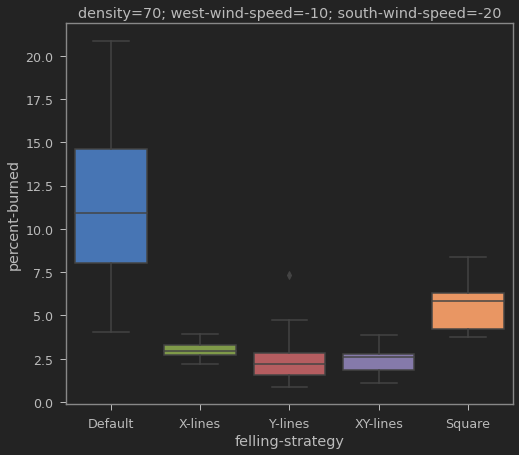

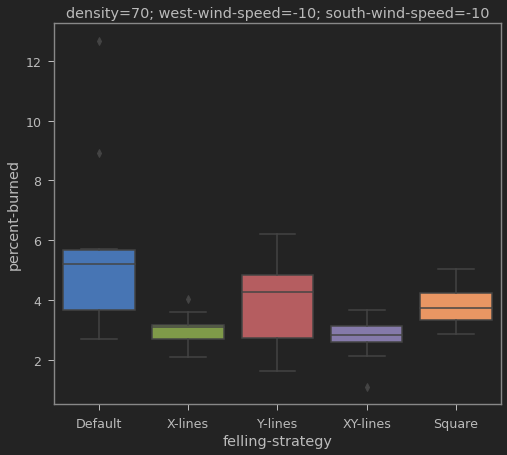

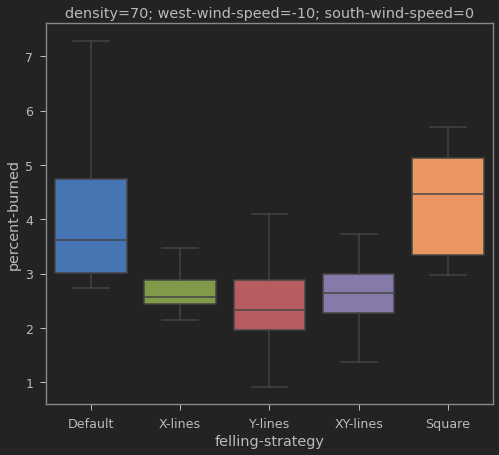

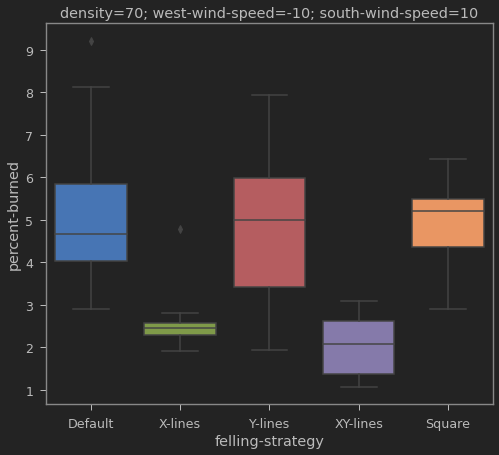

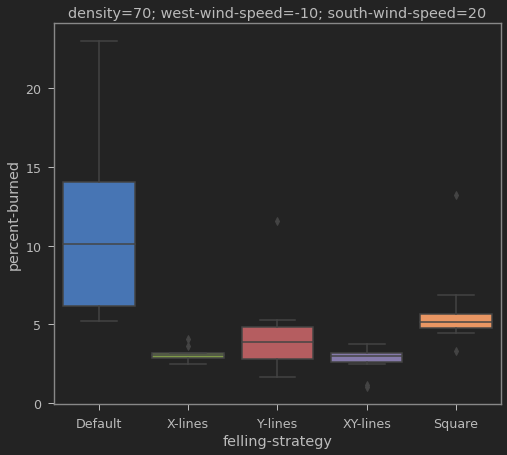

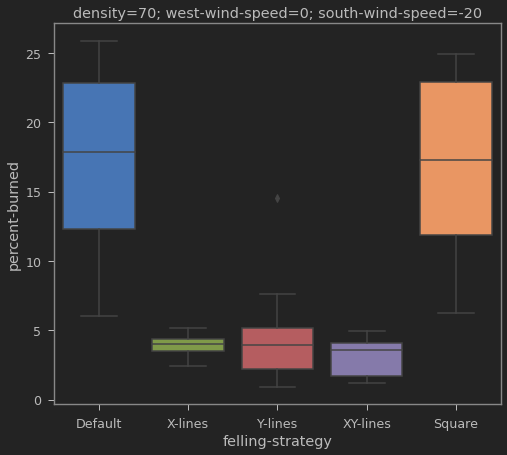

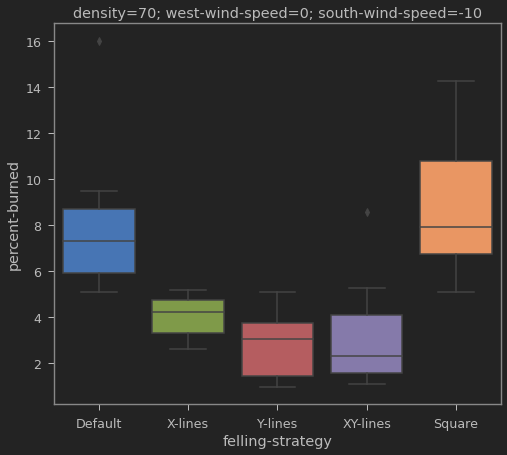

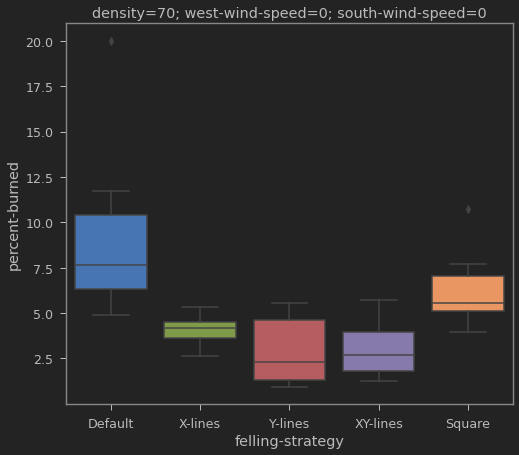

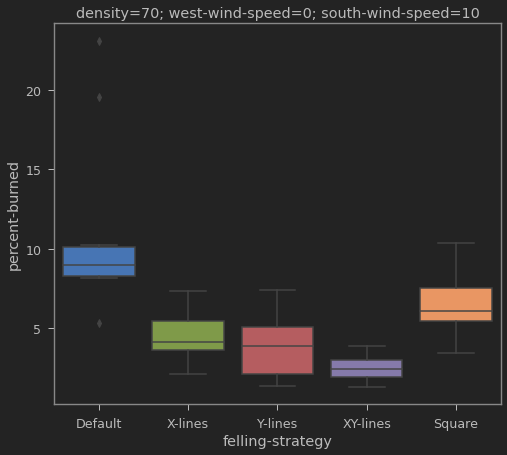

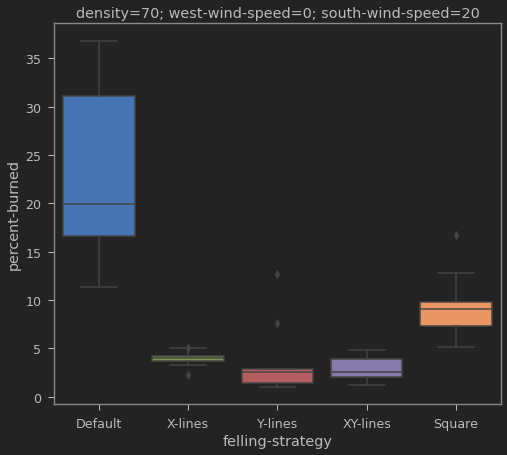

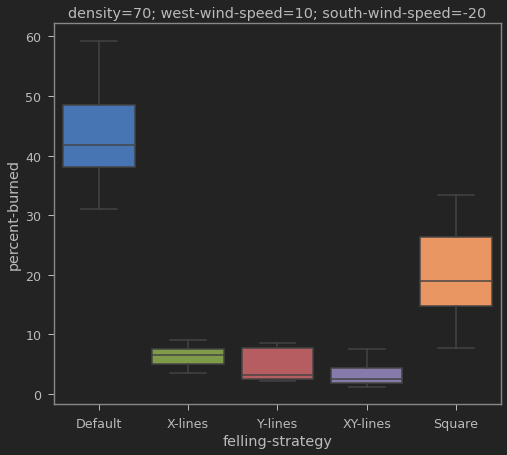

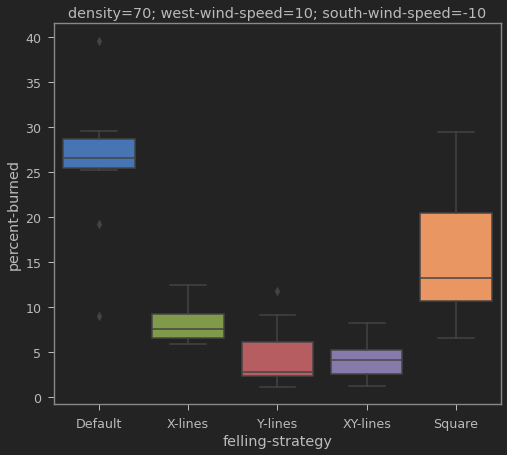

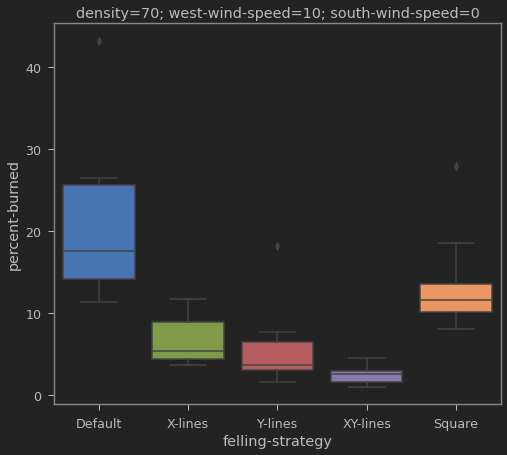

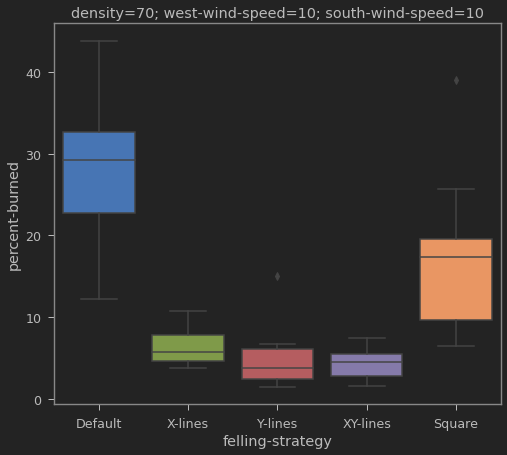

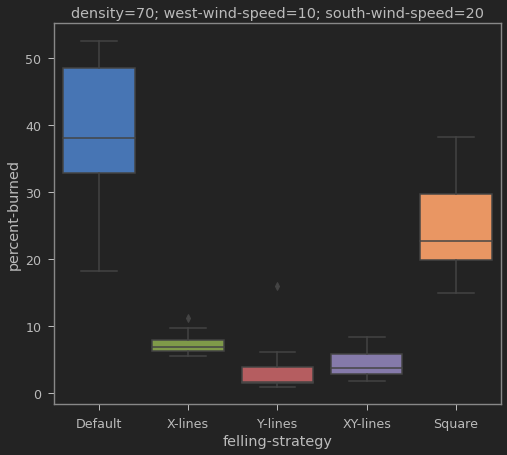

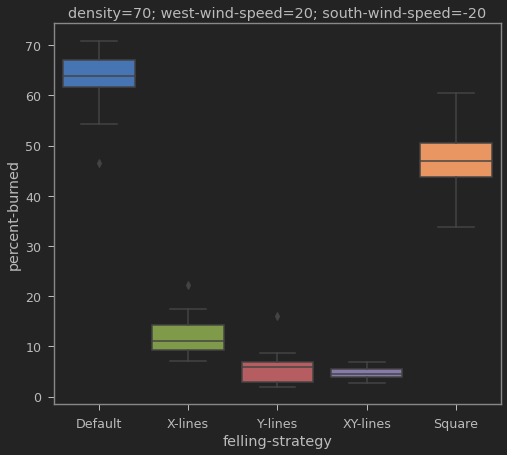

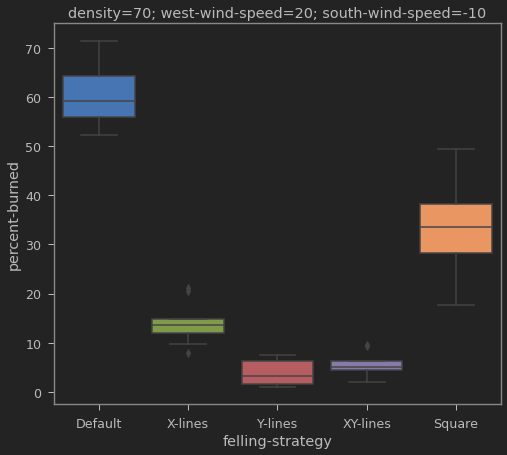

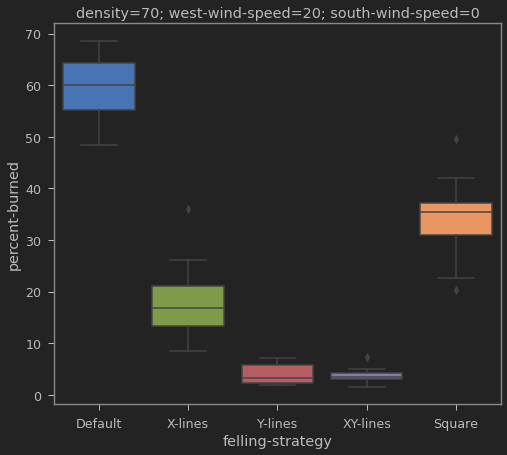

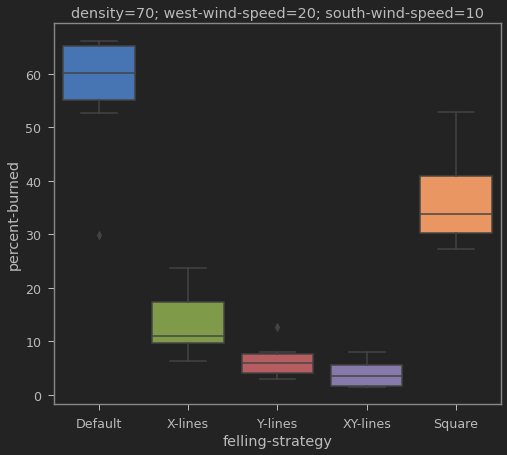

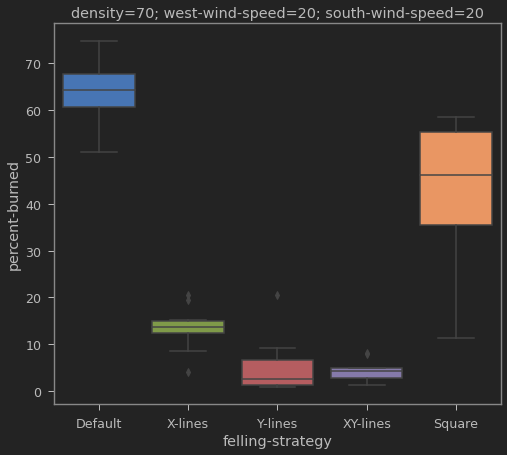

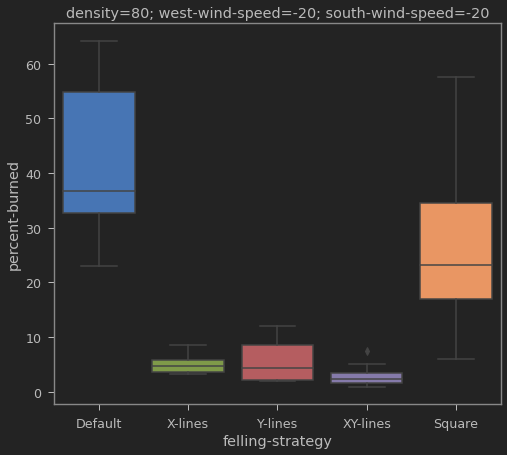

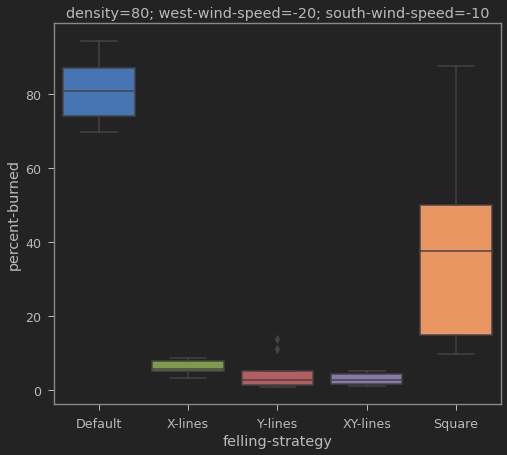

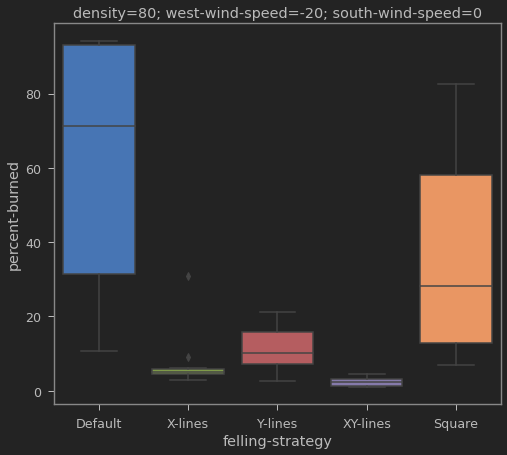

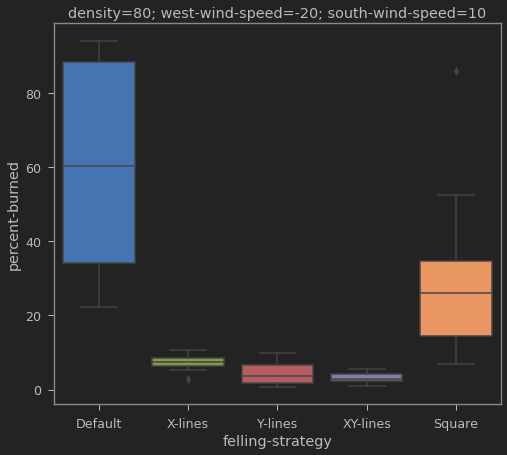

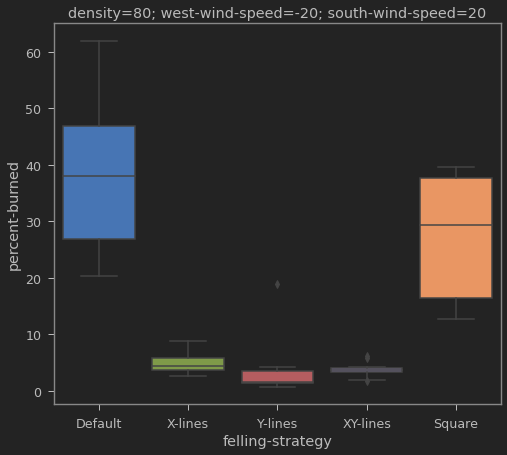

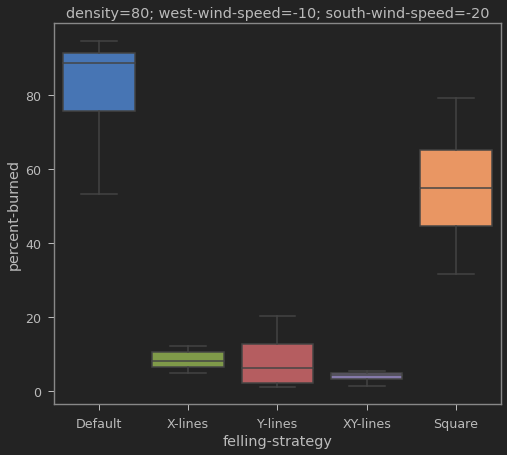

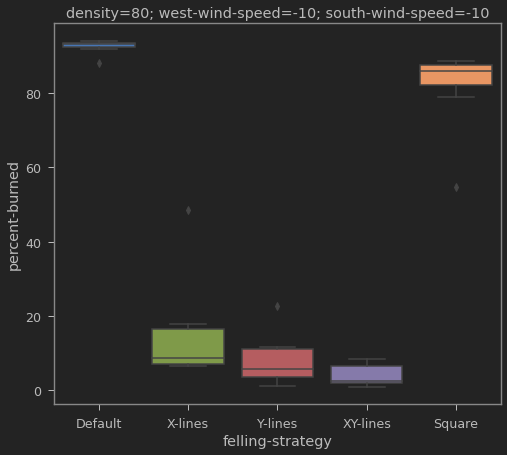

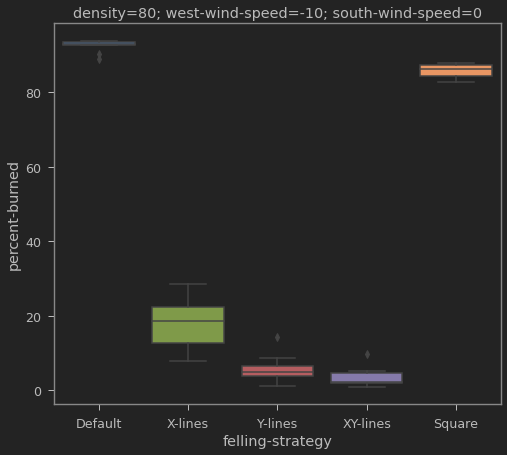

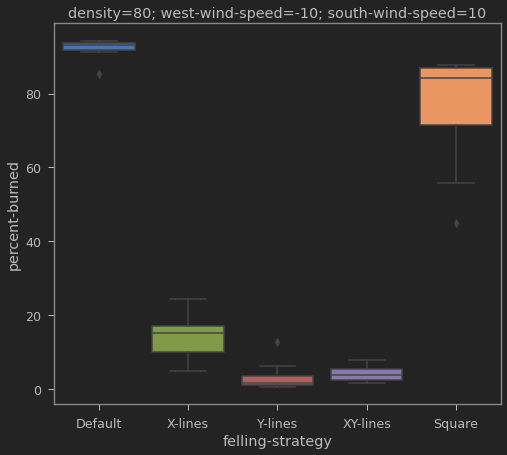

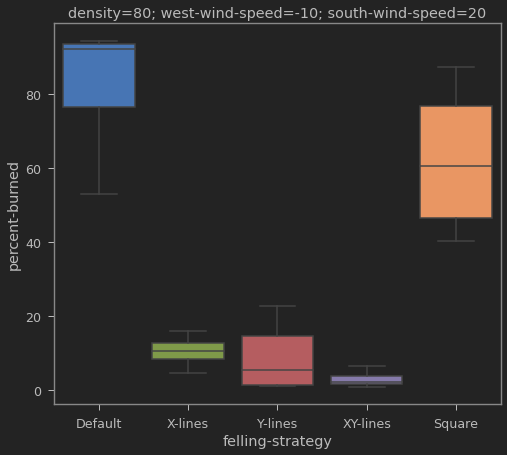

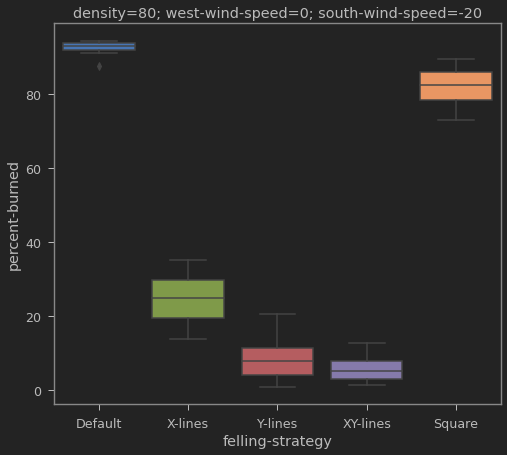

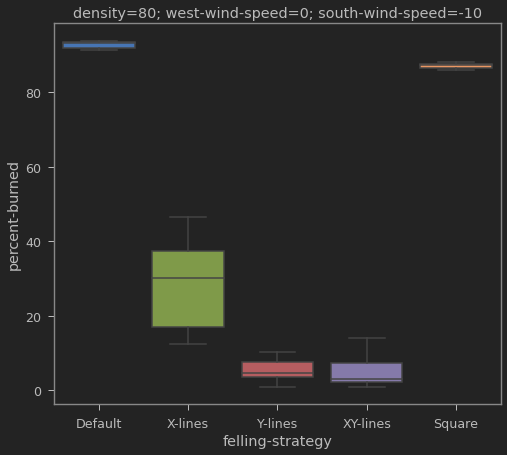

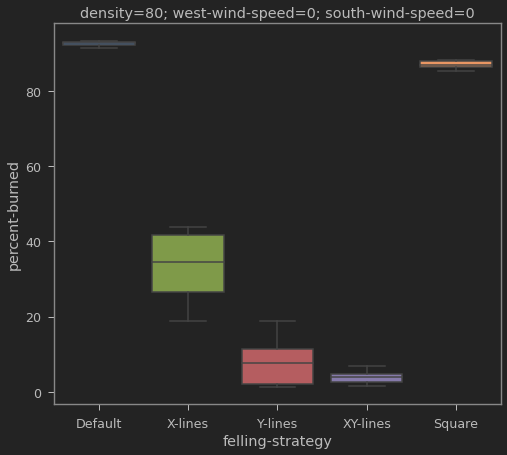

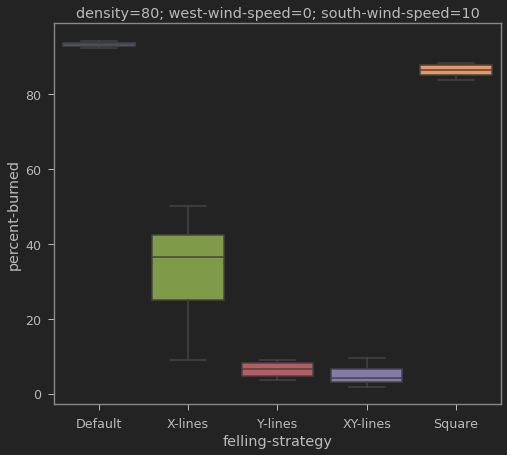

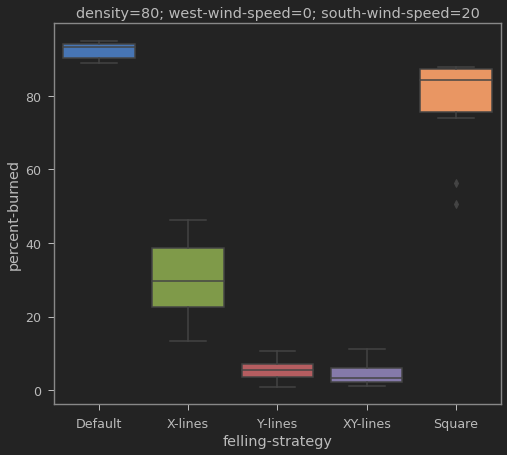

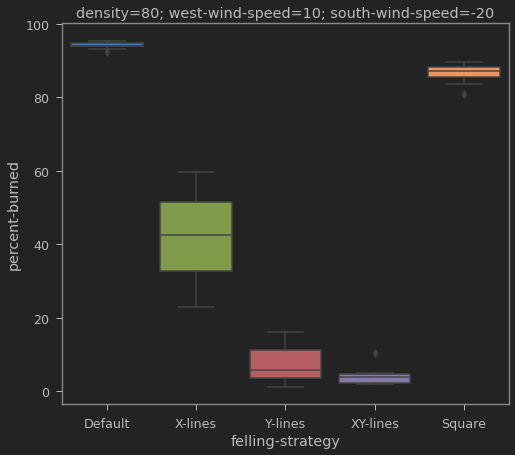

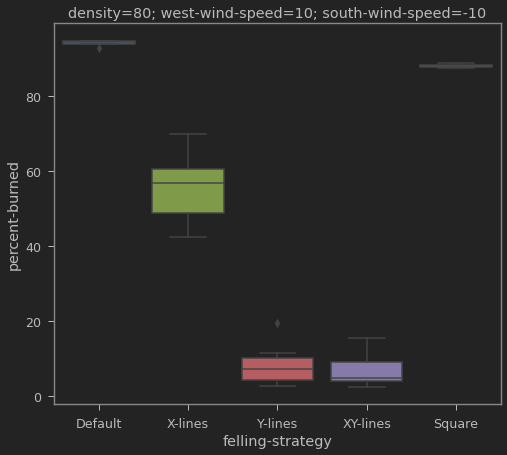

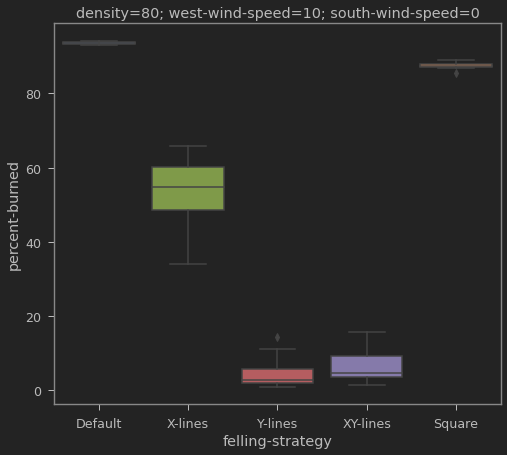

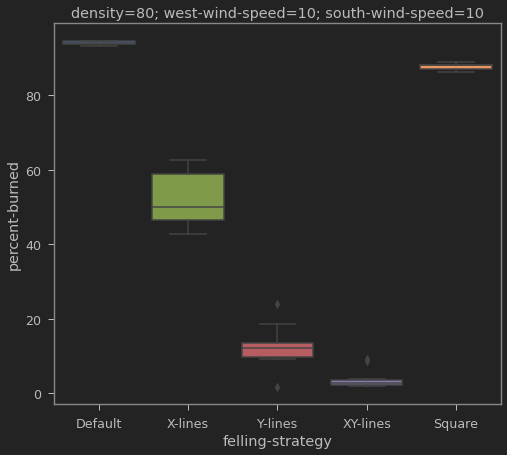

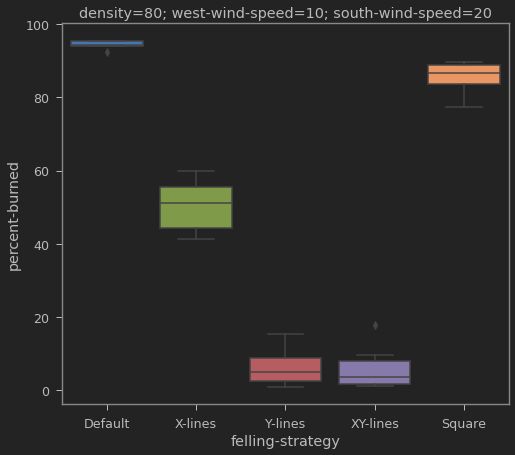

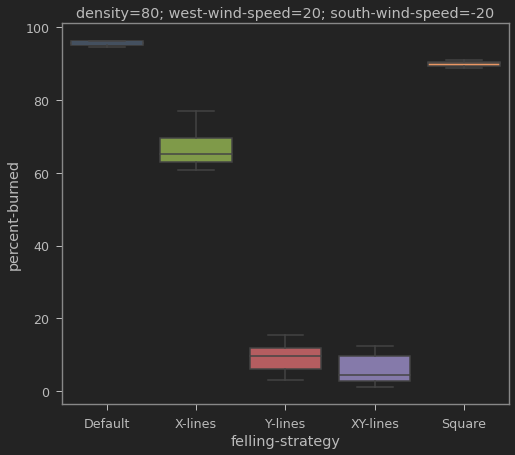

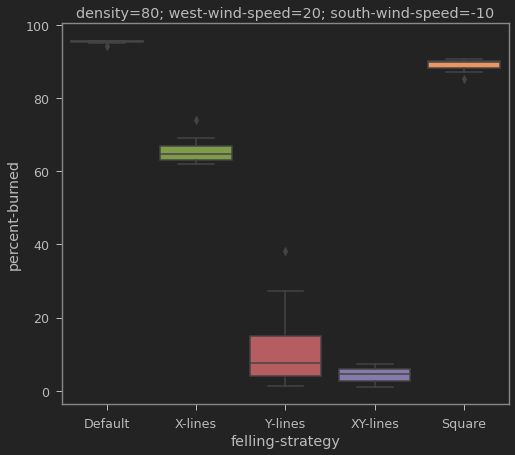

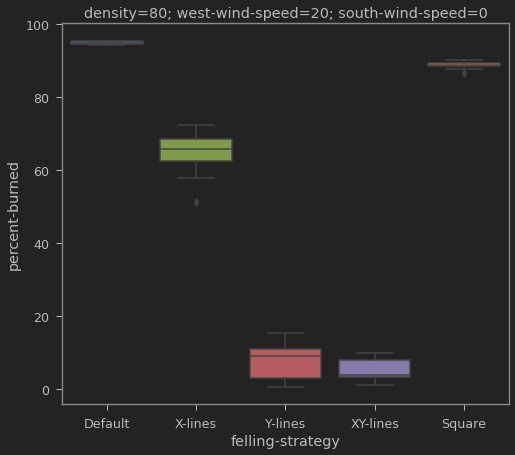

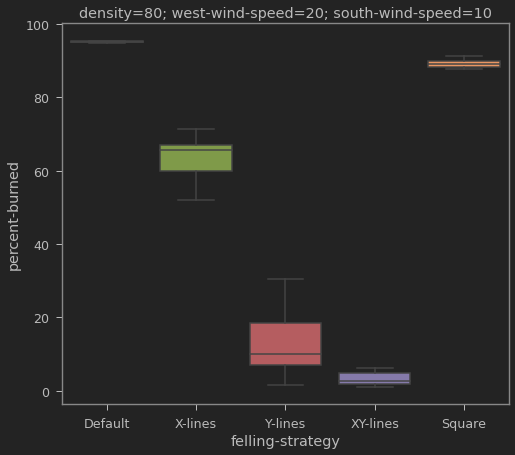

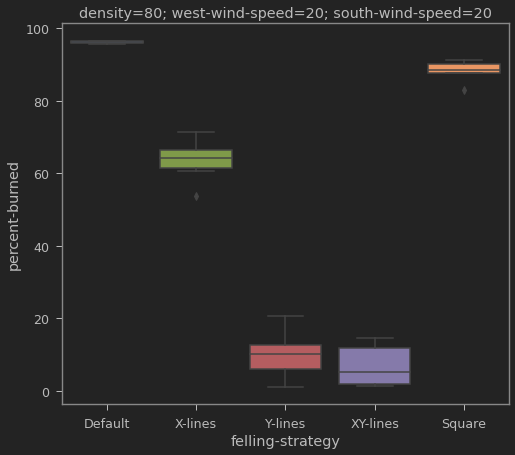

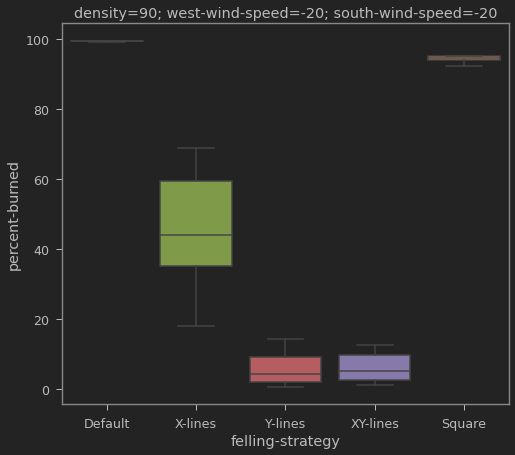

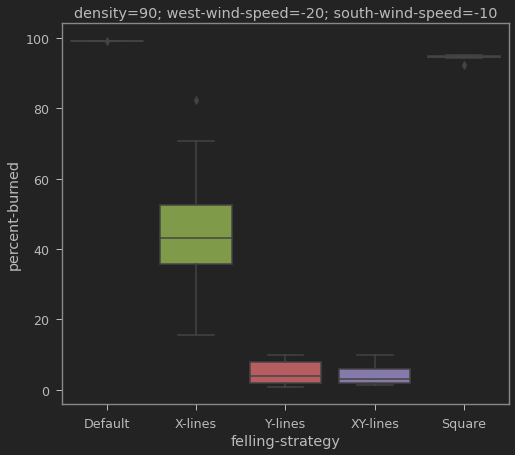

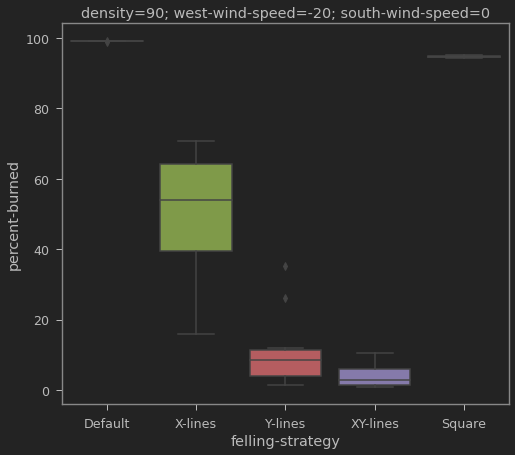

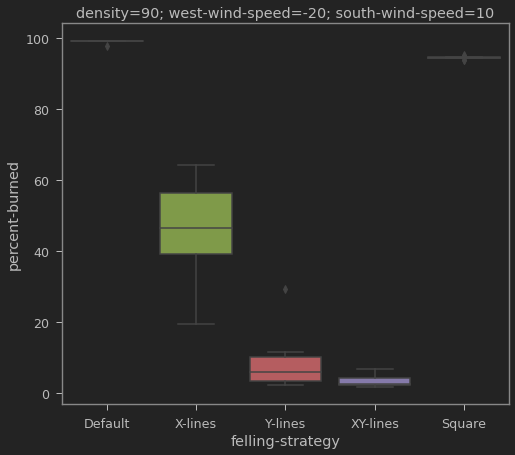

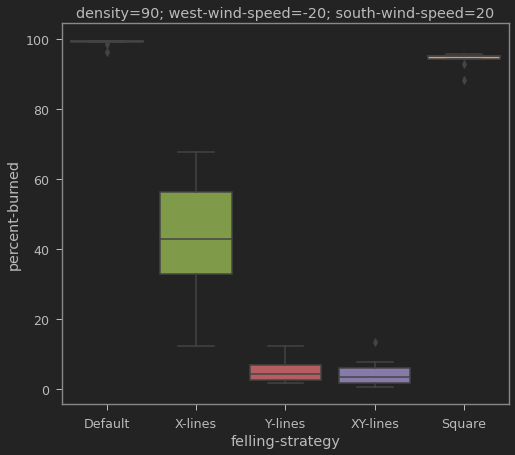

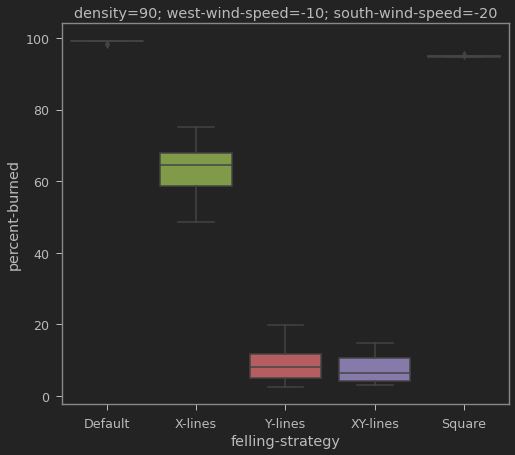

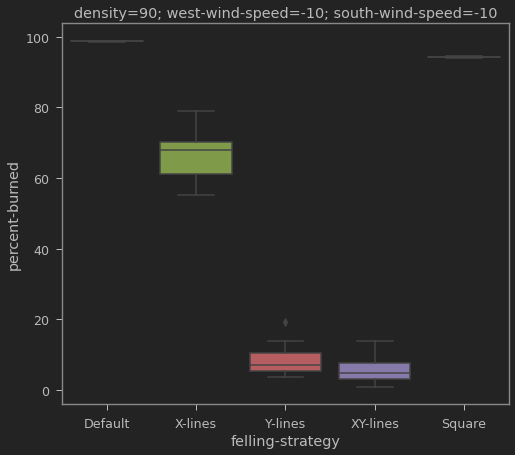

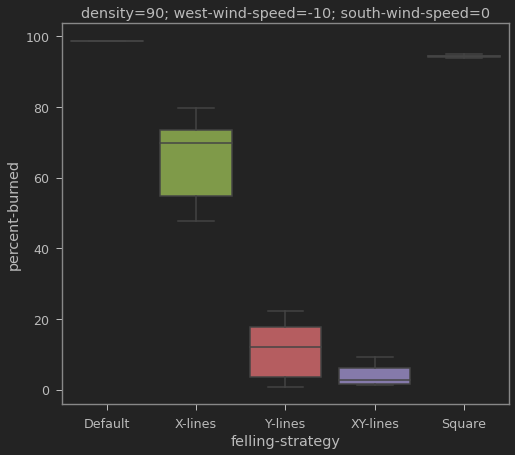

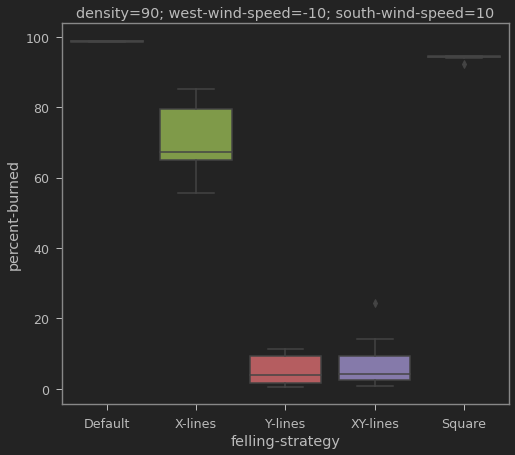

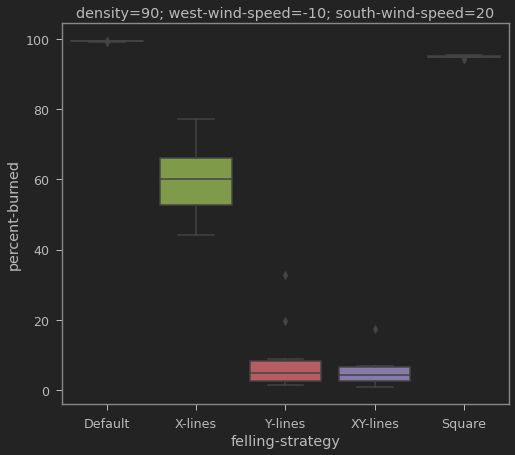

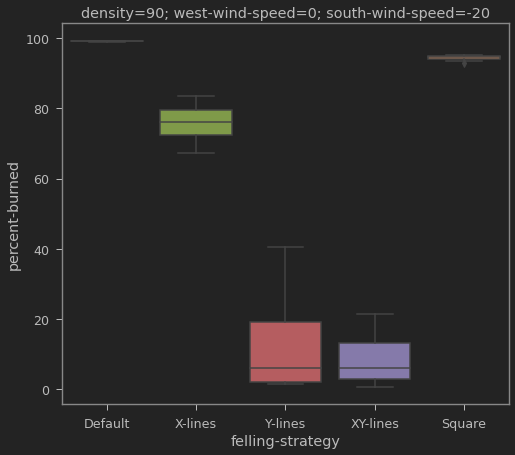

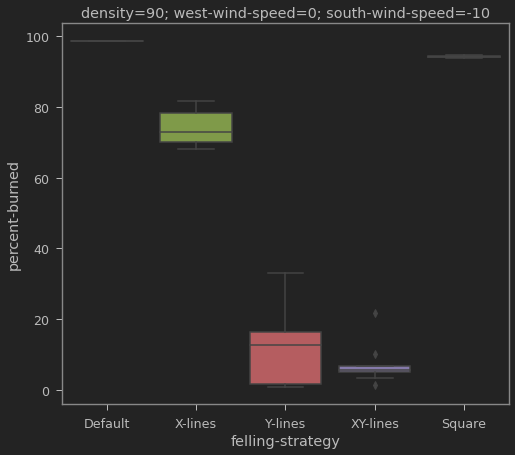

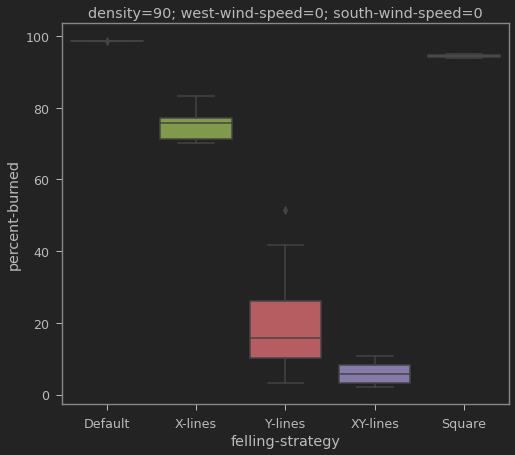

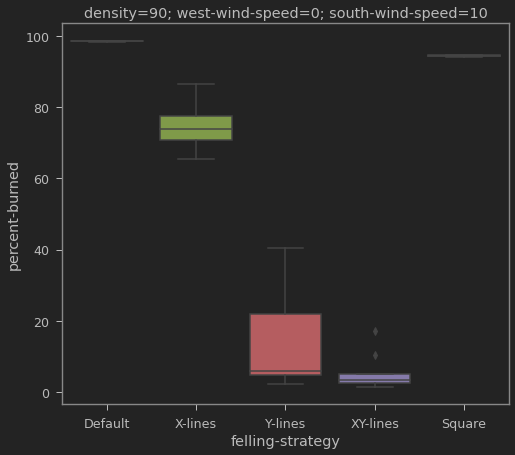

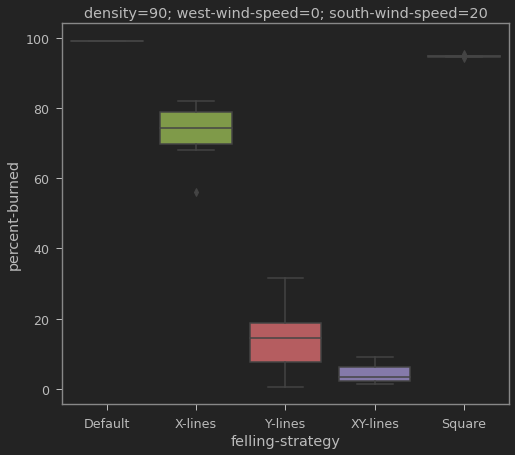

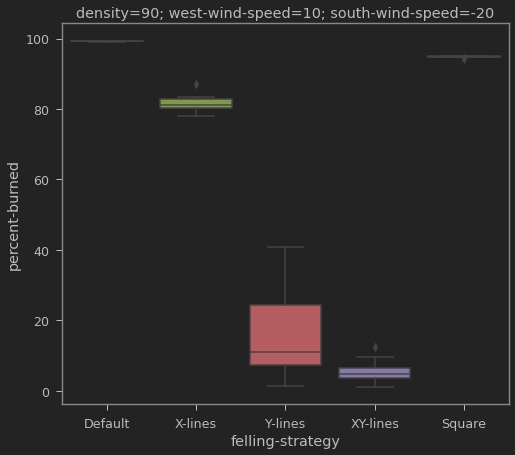

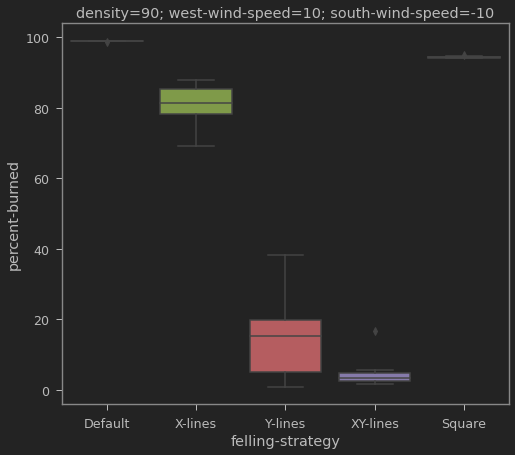

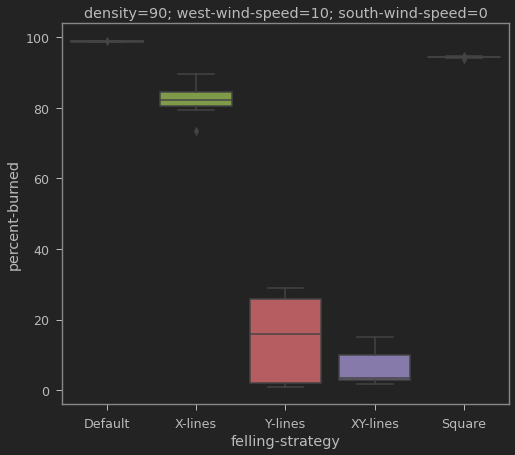

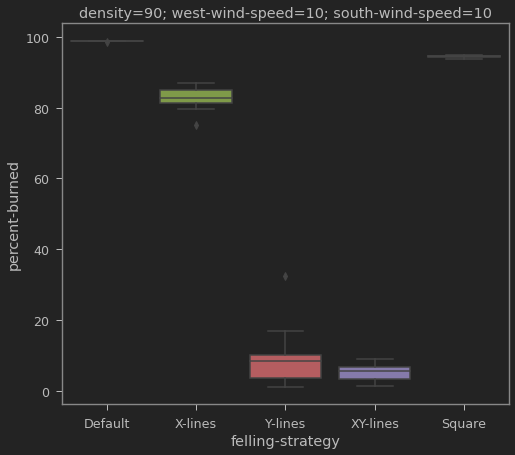

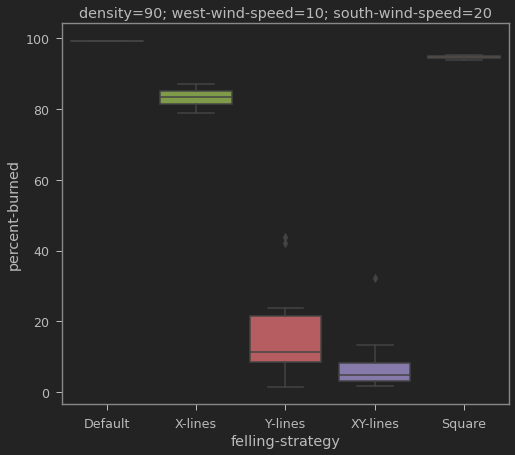

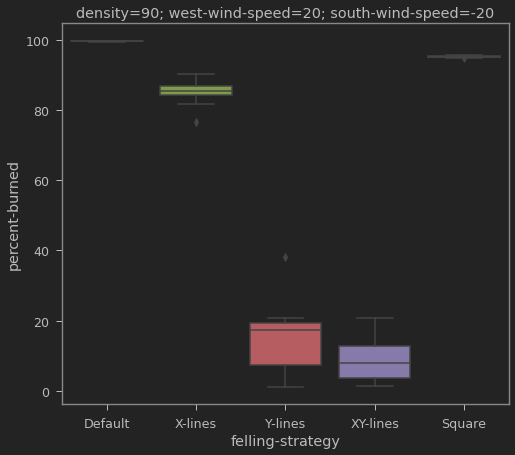

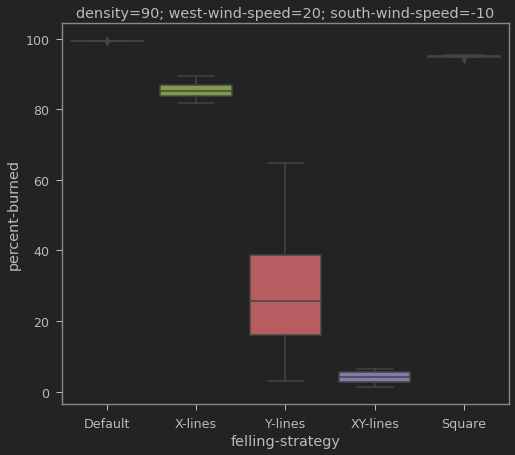

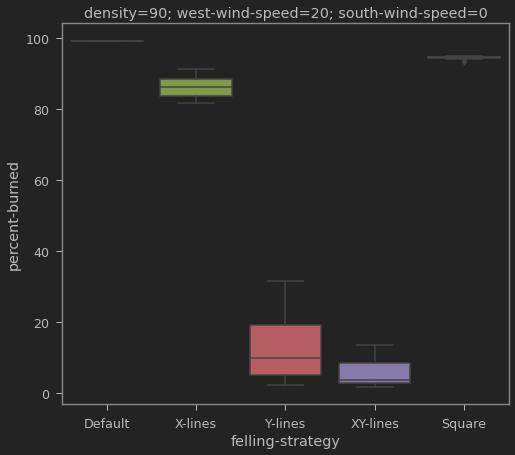

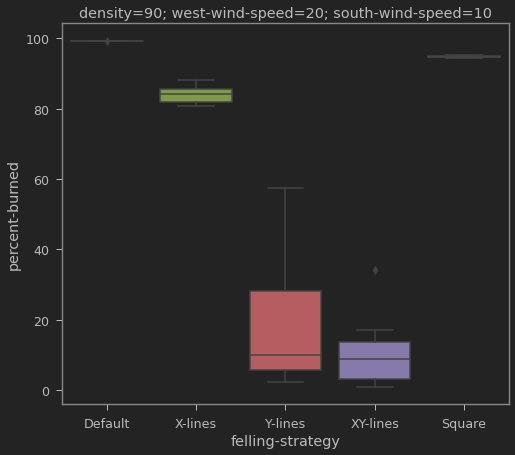

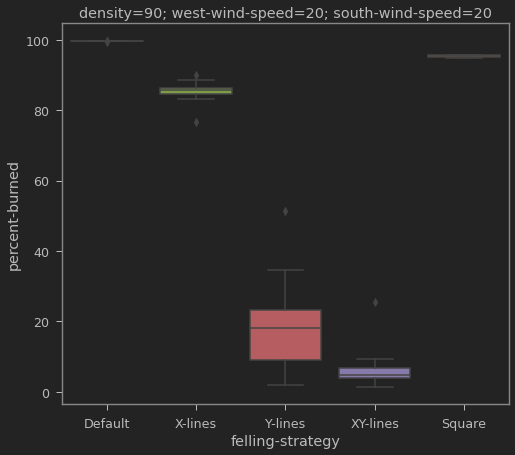

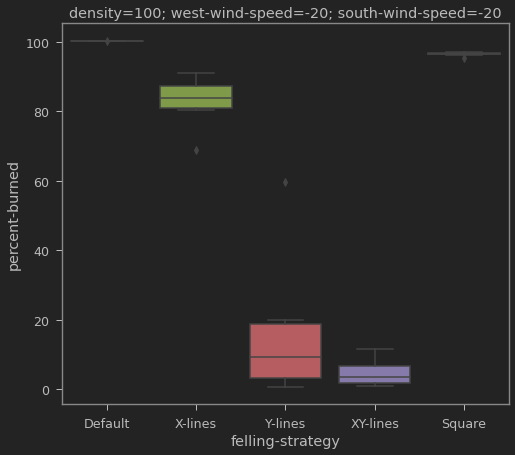

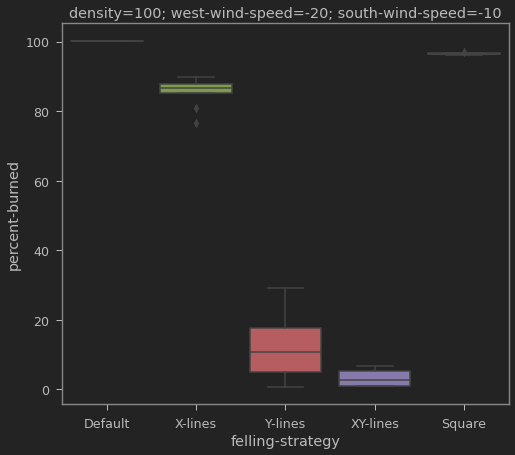

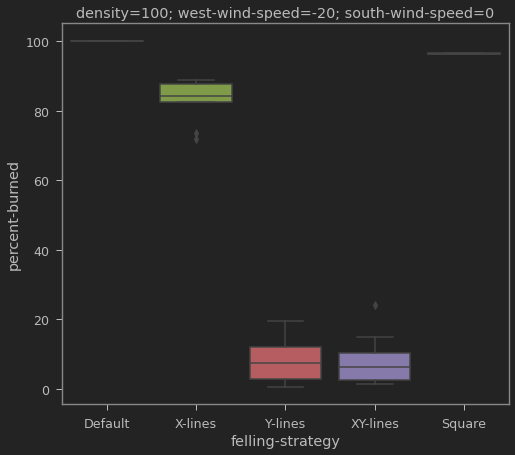

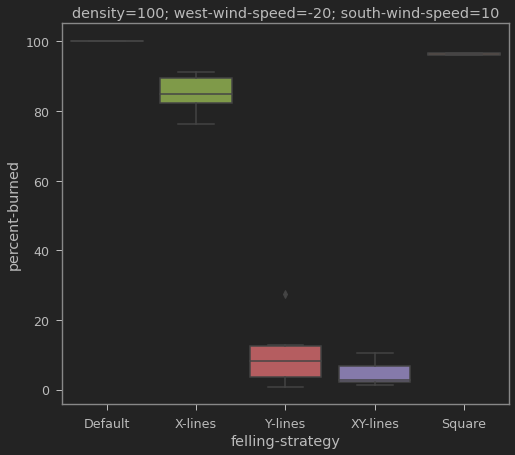

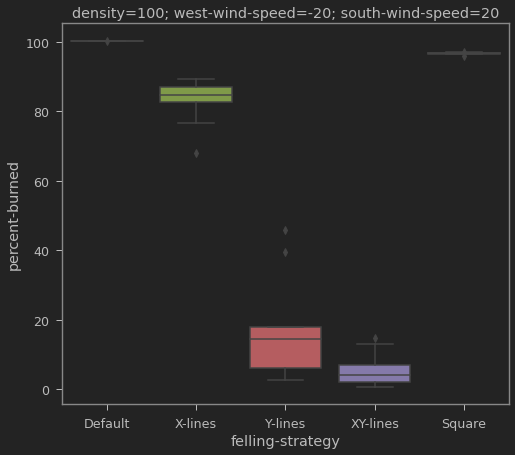

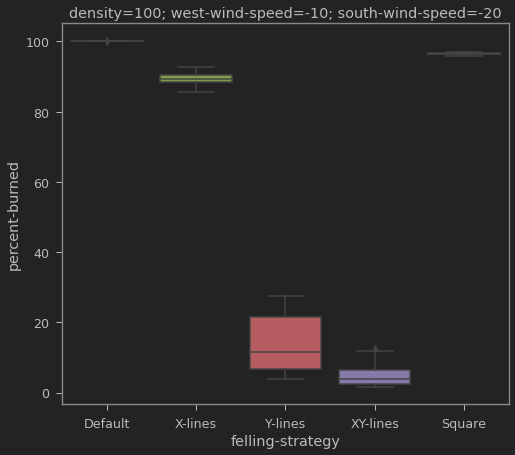

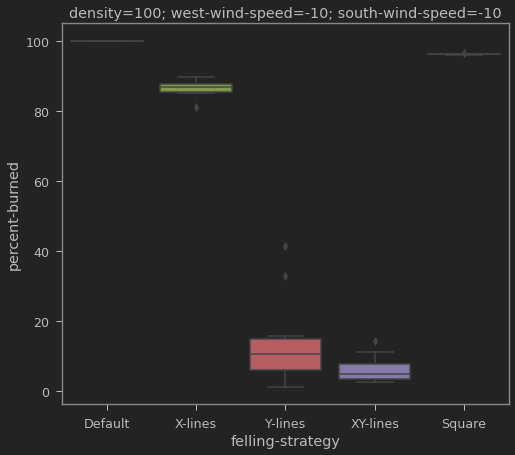

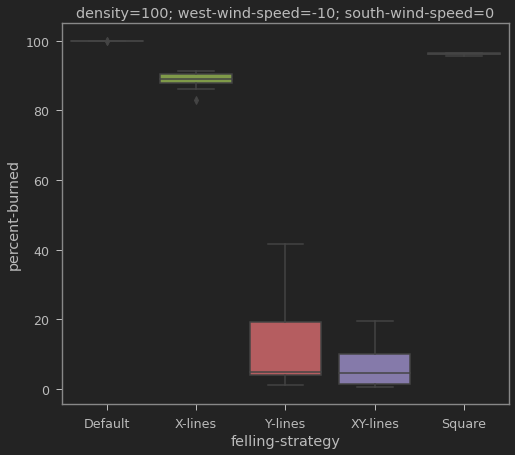

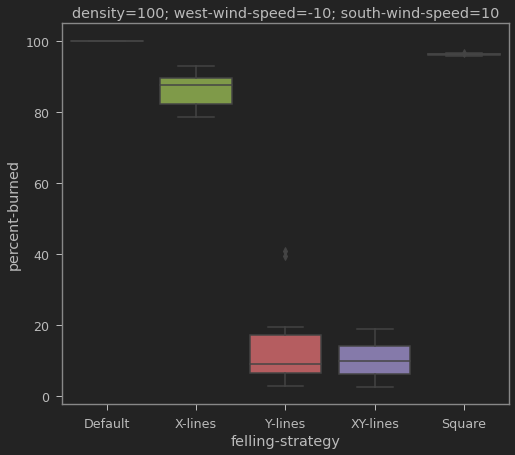

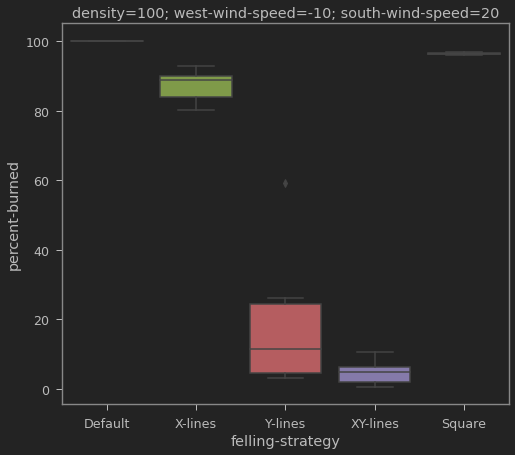

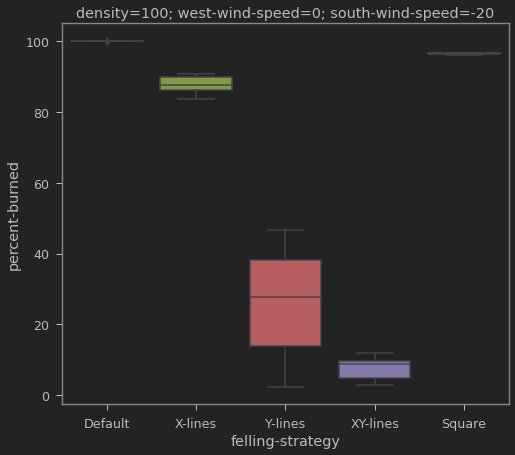

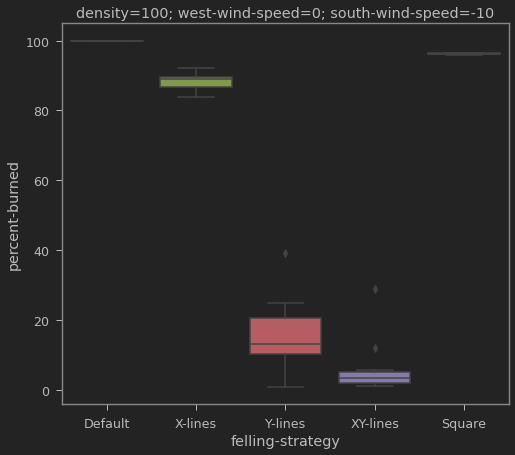

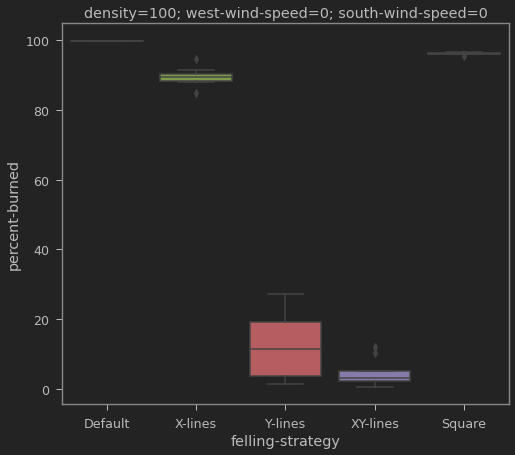

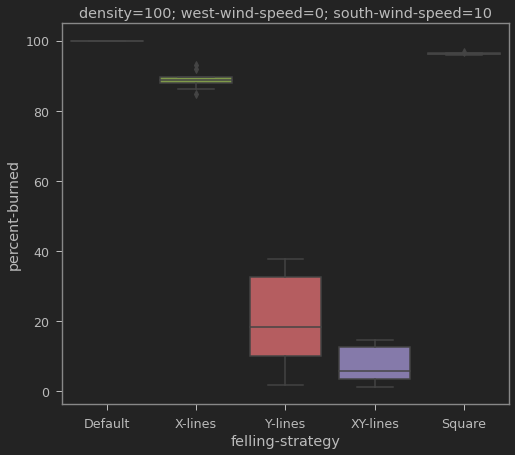

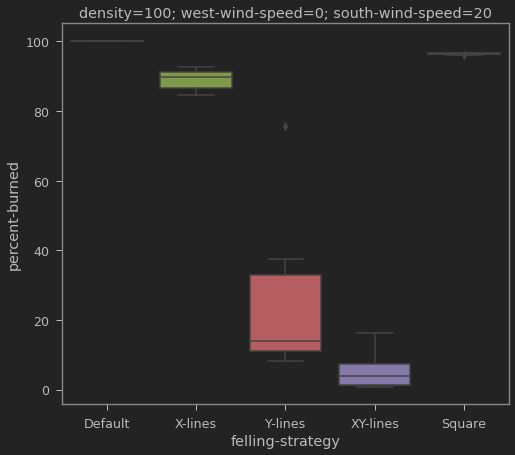

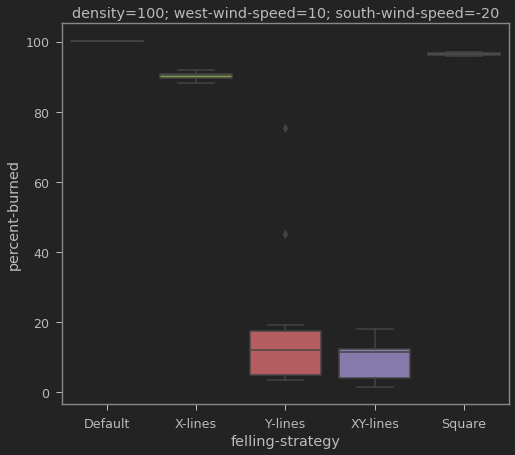

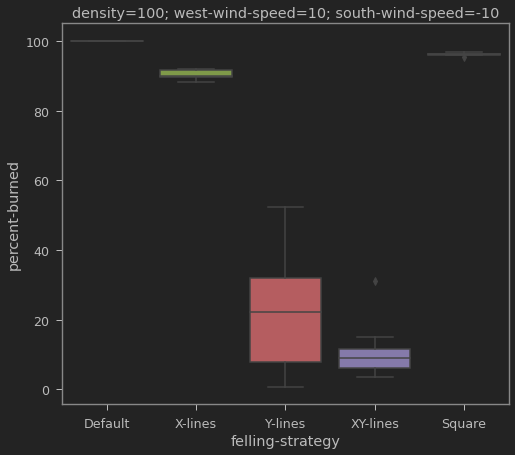

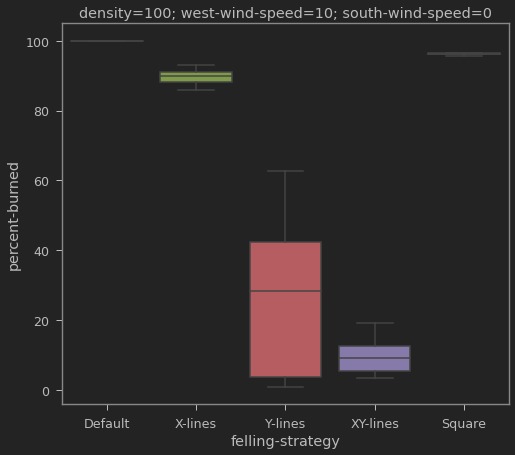

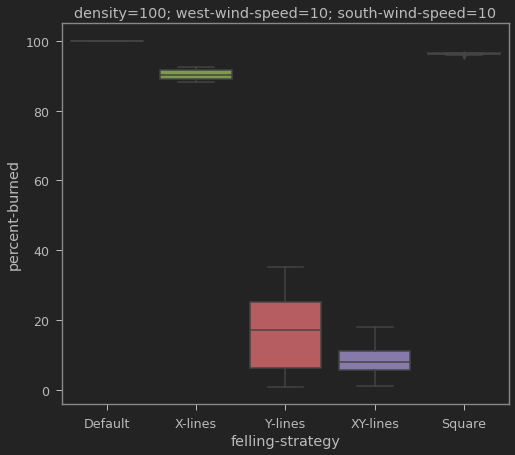

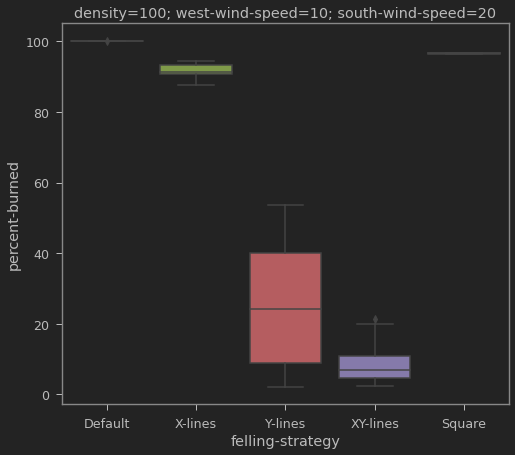

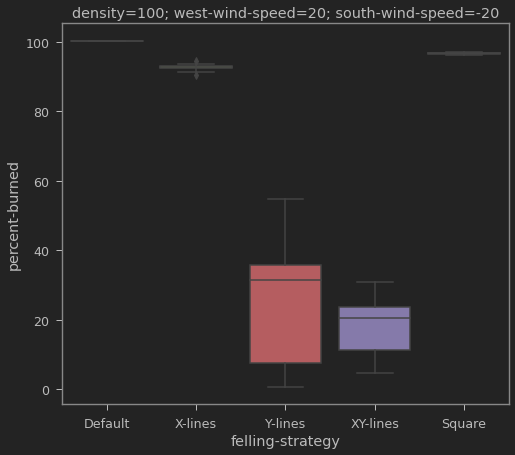

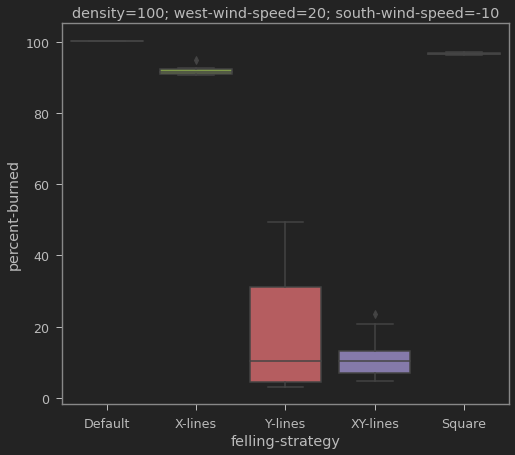

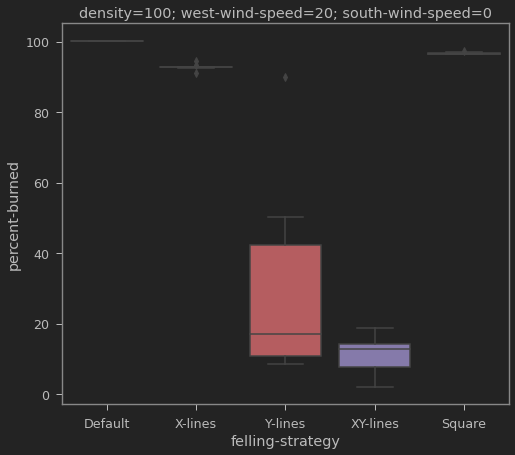

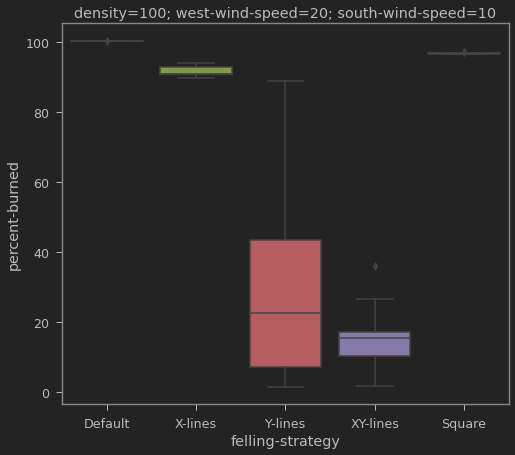

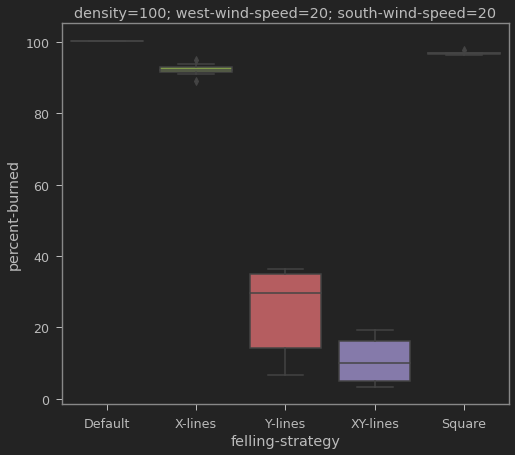

In [45]:
for density, west, south in df_2_res[['density', 'west-wind-speed', 'south-wind-speed']].drop_duplicates().values:
    t = df_2_res[(df_2_res['density'] == density)&(df_2_res['west-wind-speed'] == west)&(df_2_res['south-wind-speed'] == south)]
    
    sns.boxplot(data=t, x='felling-strategy', y='percent-burned');
    plt.title(f'density={density}; west-wind-speed={west}; south-wind-speed={south}')
    plt.show()

In [19]:
df_2.head(1)

[run number]  density  probability-of-felling  count-of-felling-points  \
0             3       20                      50                       20   

   probability-of-spread  west-wind-speed  width-of-felling  south-wind-speed  \
0                     75              -20                 5               -20   

  felling-strategy  [step]  percent-burned  
0          Default       4         2.20559

## Conclusion